## Problem:
Describe a persona [classify] of wether the next patient that is administered basic laboratory tests would require to be admitted in to the hospital (incare patient) or can be treated within the out-patient department of the hospital itself.

## Aims and Methods: 
For this classification we aim to test a suite of supervisory classification algorithms, namely:
1. Logistic Regression
2. Support Vector Machine
3. K-Nearest Neighbour
4. Random Forest

We will use the **'SOURCE'** column that classifies each patient as **'IN'** or **'OUT'** as the target variable for the classification process.

## Data Collection:
Dataset used is the Electronic Health Record (EHC) obtained from a private hospital in Indonesia. It contains the patients laboratory test results.

## Exploratory Data Analysis:

In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import shapiro, mstats, jarque_bera
sns.set()

# For pltoly graphs
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Load the Data:

In [2]:
data  = pd.read_csv('data-ori.csv')
data.tail(5)

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
4407         32.8          10.4         3.49        8.1           72  29.8   
4408         33.7          10.8         3.67        6.7           70  29.4   
4409         33.2          11.2         3.47        7.2          235  32.3   
4410         31.5          10.4         3.15        9.1          187  33.0   
4411         33.5          10.9         3.44        5.8          275  31.7   

      MCHC    MCV  AGE SEX SOURCE  
4407  31.7   94.0   92   F     in  
4408  32.0   91.8   92   F     in  
4409  33.7   95.7   93   F    out  
4410  33.0  100.0   98   F     in  
4411  32.5   97.4   99   F    out

In [3]:
# Set Encoding labels for the target variable 'SORUCE'
data['SOURCE'] = data['SOURCE'].replace({'in': 1, 'out': 0})

# List all the features of the dataset
features = [col for col in data.columns if col != 'SOURCE']

#List the categorical and numerical features
num_feats = [numf for numf in features if data[numf].dtype != object]
cat_feats = [catf for catf in features if data[catf].dtype == object]
print(f'The feature table contains:\n1. {len(num_feats)} numerical feature[s] -', end=' ')
print(*num_feats, sep=', ')
print(f'2. {len(cat_feats)} categorical feature[s] -', end=' ')
print(*cat_feats)

The feature table contains:
1. 9 numerical feature[s] - HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, LEUCOCYTE, THROMBOCYTE, MCH, MCHC, MCV, AGE
2. 1 categorical feature[s] - SEX


Add NULL data

In [4]:
data_null = data.sample(100)

# Define the columns that can be made null (excluding 'SOURCE')
modifiable_columns = data_null.columns.drop(['SOURCE', 'SEX'])

# Randomly select up to 2 columns per row to set as NaN
np.random.seed(42)  # for reproducibility
for index, row in data_null.iterrows():
    chosen_columns = np.random.choice(modifiable_columns, size=min(2, len(modifiable_columns)), replace=False)
    data_null.loc[index, chosen_columns] = np.nan

data = pd.concat([data, data_null], axis=0)
data.reset_index(drop=True, inplace=True)
data

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
0            35.1          11.8         4.65        6.3        310.0  25.4   
1            43.5          14.8         5.39       12.7        334.0  27.5   
2            33.5          11.3         4.74       13.2        305.0  23.8   
3            39.1          13.7         4.98       10.5        366.0  27.5   
4            30.9           9.9         4.23       22.1        333.0  23.4   
...           ...           ...          ...        ...          ...   ...   
4507         44.6          15.2          NaN       14.0          NaN  28.2   
4508         41.6           NaN         4.69        4.4        335.0  29.6   
4509          NaN           9.7         3.52       10.6        293.0  27.6   
4510         43.1          14.0         4.46        4.2        218.0  31.4   
4511         38.3          12.3         5.19        NaN        124.0  23.7   

      MCHC   MCV   AGE SEX  SOURCE  
0     33.6  75.5   1.0   F       0  
1     34.0  80.7   1.0   F       0  
2     33.7  70.7   1.0   F       0  
3     35.0  78.5   1.0   F       0  
4     32.0  73.0   1.0   M       0  
...    ...   ...   ...  ..     ...  
4507  34.1  82.7  18.0   M       0  
4508   NaN  88.7  40.0   M       0  
4509   NaN  88.6  65.0   F       0  
4510   NaN  96.6   NaN   F       0  
4511  32.1   NaN  22.0   F       0  

[4512 rows x 11 columns]

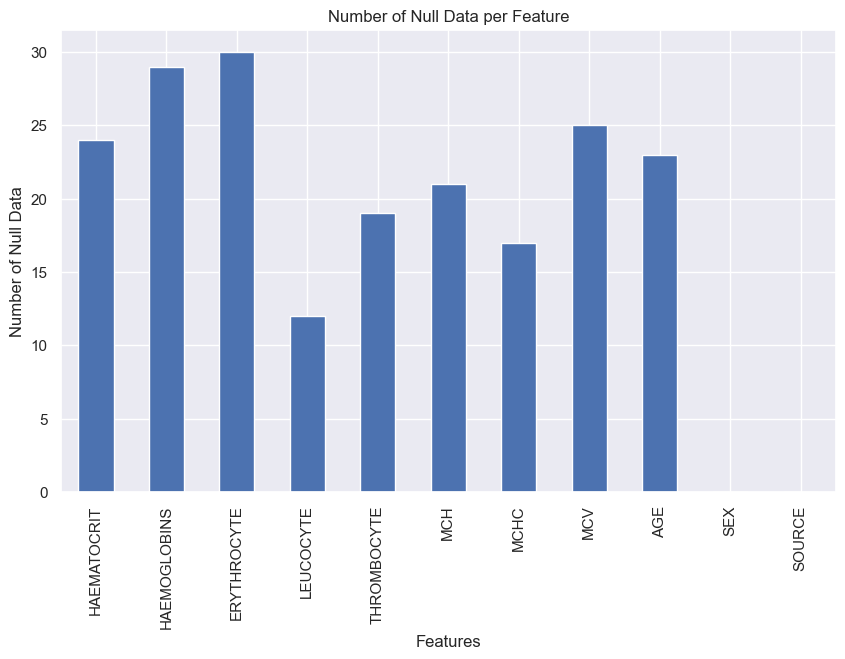

In [5]:
# Calculate the number of null values per feature
null_counts = data.isnull().sum()

# Visualizing the number of null values per feature
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.title('Number of Null Data per Feature')
plt.xlabel('Features')
plt.ylabel('Number of Null Data')
plt.show()

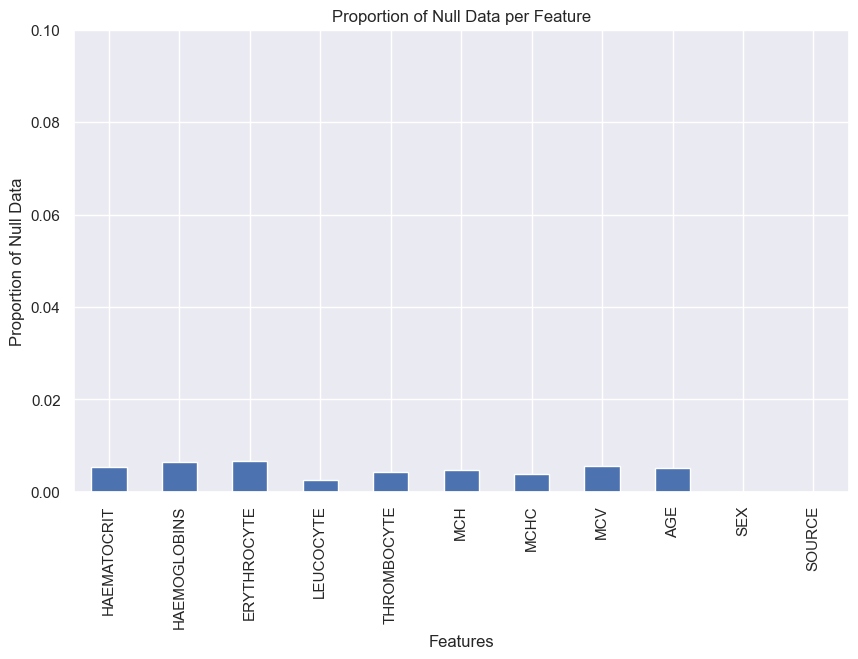

In [6]:
# Calculate the number of null values per feature
null_counts = data.isnull().sum() / data.shape[0]

# Visualizing the number of null values per feature
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar')
plt.title('Proportion of Null Data per Feature')
plt.xlabel('Features')
plt.ylabel('Proportion of Null Data')
plt.ylim(0, 0.1)
plt.show()

In [7]:
data.loc[data.isnull().any(axis=1), :]

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
4412         43.7           NaN         4.99       10.0        291.0  29.1   
4413          NaN           NaN         5.64        9.8        234.0  31.2   
4414         35.5          11.0          NaN        6.5        354.0  23.9   
4415         34.9           NaN         4.34        7.8        346.0  25.1   
4416         27.6           NaN         3.93       17.1        153.0   NaN   
...           ...           ...          ...        ...          ...   ...   
4507         44.6          15.2          NaN       14.0          NaN  28.2   
4508         41.6           NaN         4.69        4.4        335.0  29.6   
4509          NaN           9.7         3.52       10.6        293.0  27.6   
4510         43.1          14.0         4.46        4.2        218.0  31.4   
4511         38.3          12.3         5.19        NaN        124.0  23.7   

      MCHC   MCV   AGE SEX  SOURCE  
4412  33.2   NaN  57.0   M       0  
4413  33.8  92.2  46.0   M       0  
4414  31.0  77.0   NaN   F       0  
4415  31.2   NaN  22.0   F       0  
4416  35.5  70.2  56.0   M       1  
...    ...   ...   ...  ..     ...  
4507  34.1  82.7  18.0   M       0  
4508   NaN  88.7  40.0   M       0  
4509   NaN  88.6  65.0   F       0  
4510   NaN  96.6   NaN   F       0  
4511  32.1   NaN  22.0   F       0  

[100 rows x 11 columns]

# Exploratory Data Analysis (EDA)

### Features in dataset:

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4512 entries, 0 to 4511
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   4488 non-null   float64
 1   HAEMOGLOBINS  4483 non-null   float64
 2   ERYTHROCYTE   4482 non-null   float64
 3   LEUCOCYTE     4500 non-null   float64
 4   THROMBOCYTE   4493 non-null   float64
 5   MCH           4491 non-null   float64
 6   MCHC          4495 non-null   float64
 7   MCV           4487 non-null   float64
 8   AGE           4489 non-null   float64
 9   SEX           4512 non-null   object 
 10  SOURCE        4512 non-null   int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 387.9+ KB


* The dataset does not contain any missing/null values.
* For the feature list we can again see that the categorical varriable is 'SEX' as indicated by the 'object' data type.

In [9]:
# Unique values for each feature and target variables

data.nunique().to_frame('Unqiue Values')

Unqiue Values
HAEMATOCRIT             326
HAEMOGLOBINS            128
ERYTHROCYTE             433
LEUCOCYTE               276
THROMBOCYTE             554
MCH                     189
MCHC                    105
MCV                     406
AGE                      95
SEX                       2
SOURCE                    2

### Descriptive Statistics:

In [10]:
data.dropna(inplace=True)

In [11]:
data.describe(include='all')

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE    LEUCOCYTE  THROMBOCYTE  \
count   4412.000000   4412.000000  4412.000000  4412.000000  4412.000000   
unique          NaN           NaN          NaN          NaN          NaN   
top             NaN           NaN          NaN          NaN          NaN   
freq            NaN           NaN          NaN          NaN          NaN   
mean      38.197688     12.741727     4.541260     8.718608   257.524479   
std        5.974784      2.079903     0.784091     5.049041   113.972365   
min       13.700000      3.800000     1.480000     1.100000     8.000000   
25%       34.375000     11.400000     4.040000     5.675000   188.000000   
50%       38.600000     12.900000     4.570000     7.600000   256.000000   
75%       42.500000     14.200000     5.050000    10.300000   321.000000   
max       69.000000     18.900000     7.860000    76.600000  1183.000000   

                MCH         MCHC          MCV          AGE   SEX       SOURCE  
count   4412.000000  4412.000000  4412.000000  4412.000000  4412  4412.000000  
unique          NaN          NaN          NaN          NaN     2          NaN  
top             NaN          NaN          NaN          NaN     M          NaN  
freq            NaN          NaN          NaN          NaN  2290          NaN  
mean      28.234701    33.343042    84.612942    46.626473   NaN     0.404352  
std        2.672639     1.228664     6.859101    21.731218   NaN     0.490822  
min       14.900000    26.000000    54.000000     1.000000   NaN     0.000000  
25%       27.200000    32.700000    81.500000    29.000000   NaN     0.000000  
50%       28.700000    33.400000    85.400000    47.000000   NaN     0.000000  
75%       29.800000    34.100000    88.700000    64.000000   NaN     1.000000  
max       40.800000    39.000000   115.600000    99.000000   NaN     1.000000

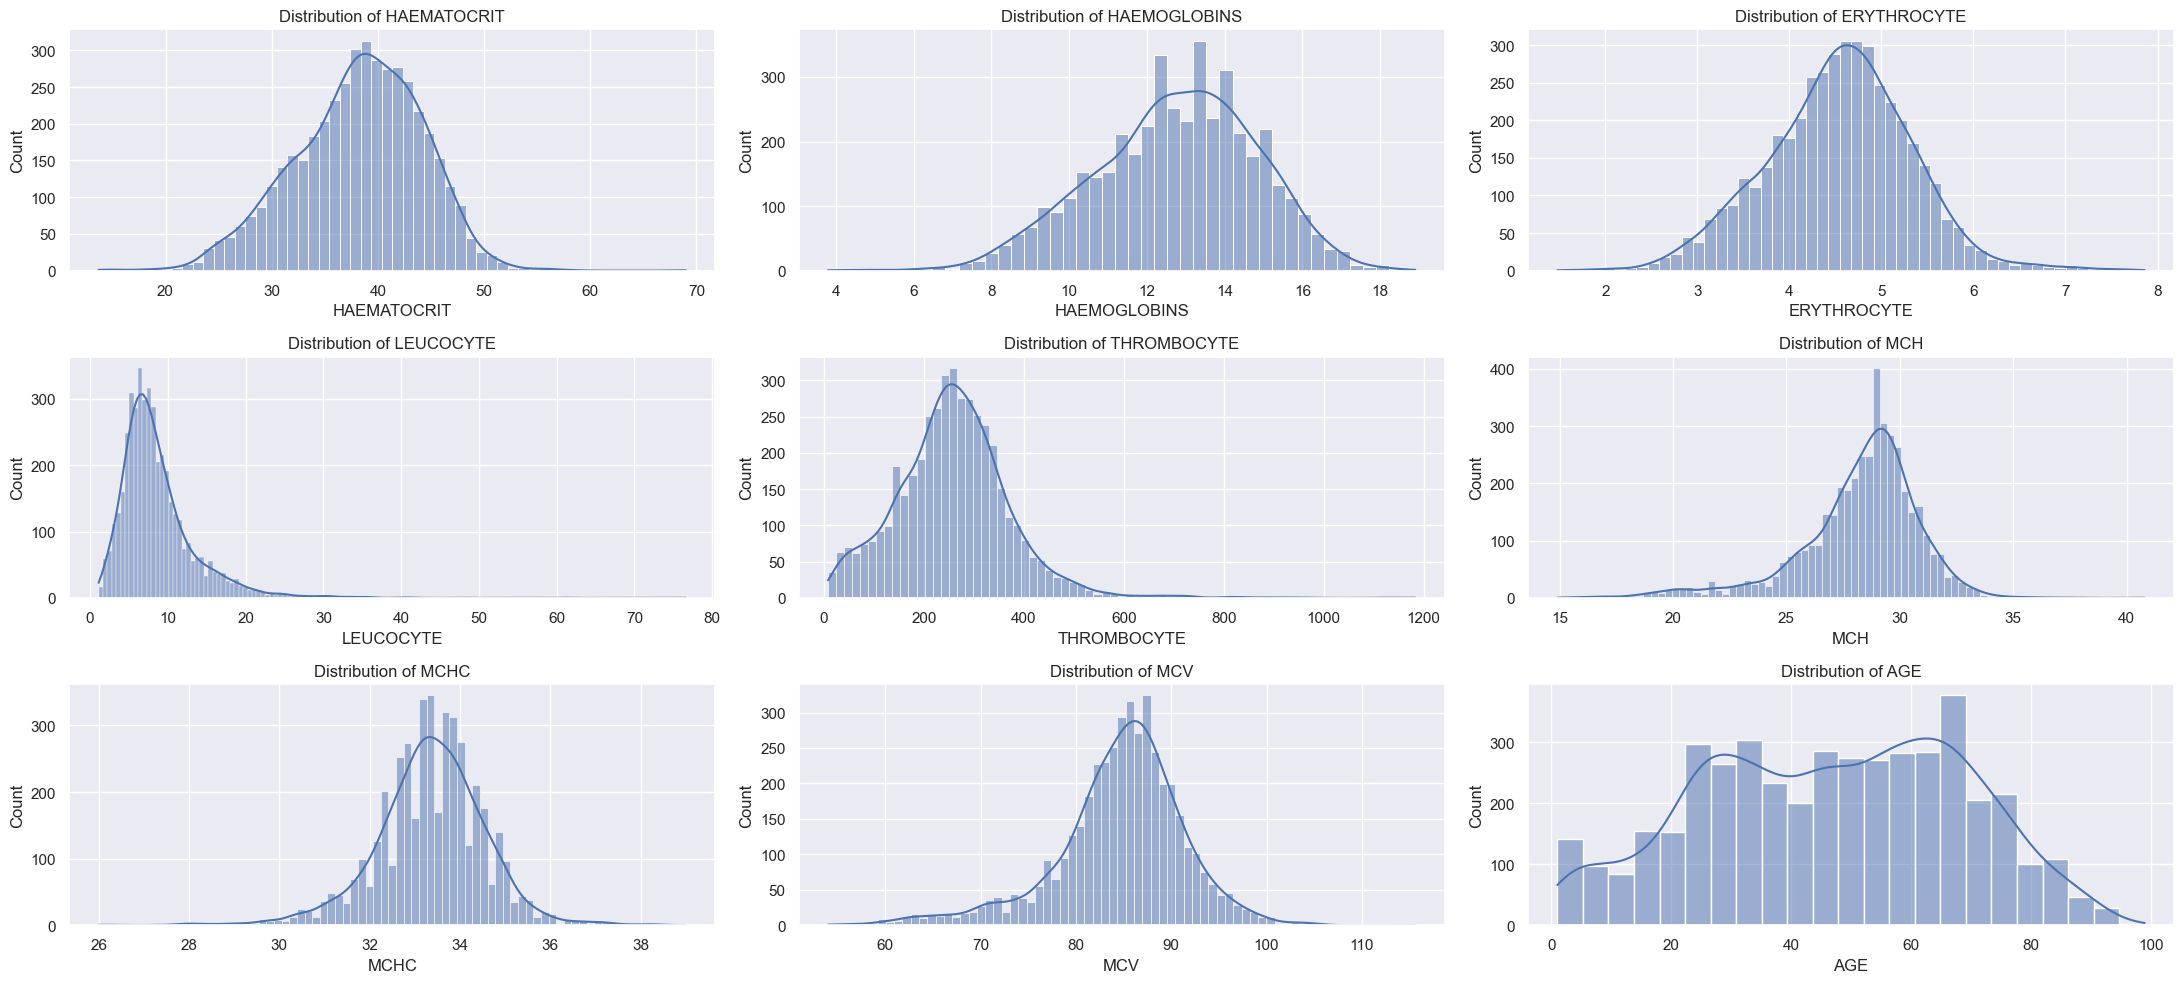

In [12]:
numeric_columns = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE',
       'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

plt.figure(figsize=(22, 10))  # Adjust the figure size based on the number of rows
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)  # 2 columns
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

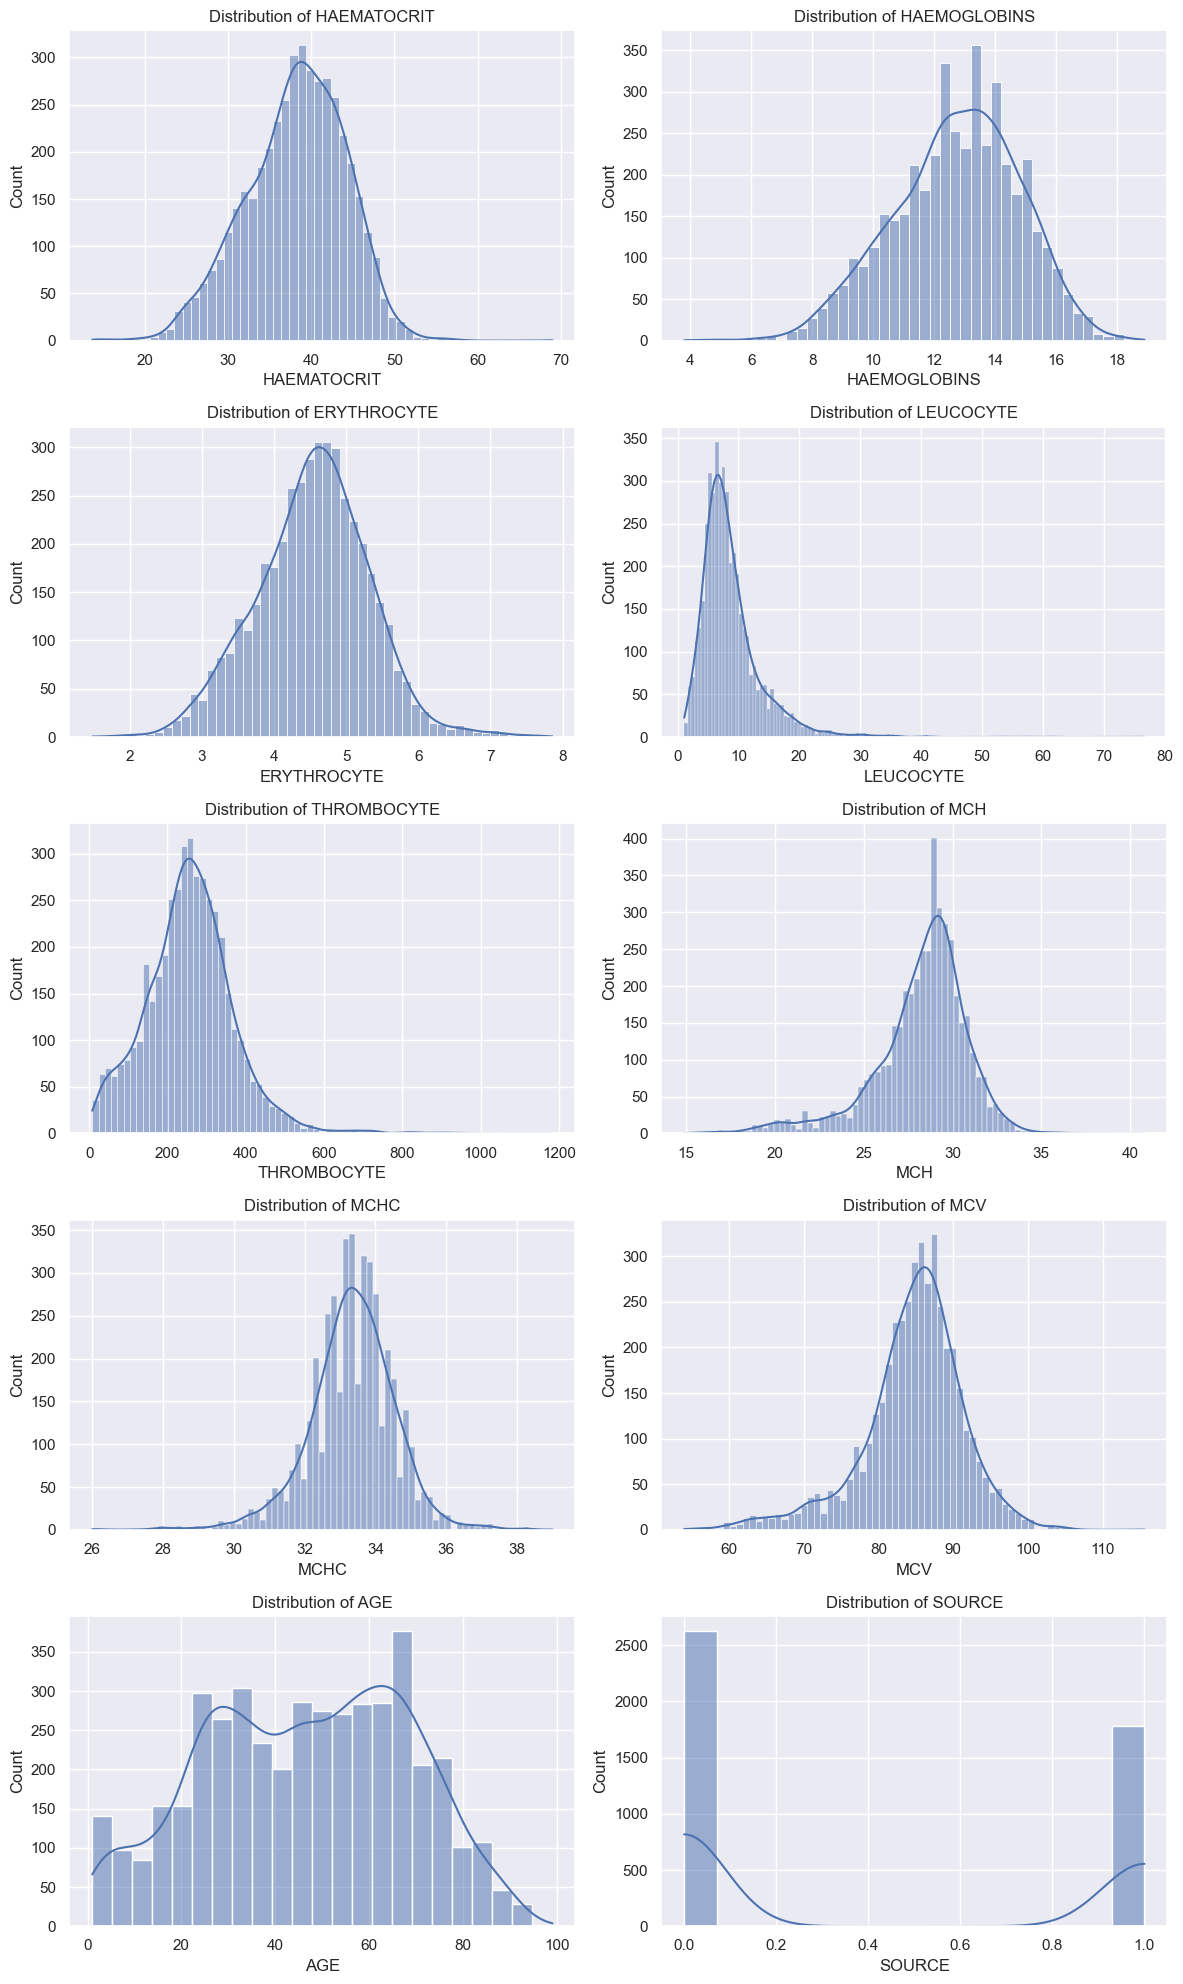

In [13]:
# Distribution of variables
numeric_columns = data.select_dtypes(include=[np.number]).columns
num_vars = len(numeric_columns)

# Calculate the number of rows needed in the subplot grid (2 columns grid here for more horizontal space)
num_rows = (num_vars + 1) // 2

plt.figure(figsize=(12, num_rows * 4))  # Adjust the figure size based on the number of rows
for i, col in enumerate(numeric_columns):
    plt.subplot(num_rows, 2, i + 1)  # 2 columns
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Normalization

Shapiro-Wilk Test/Jarque-Bera Test

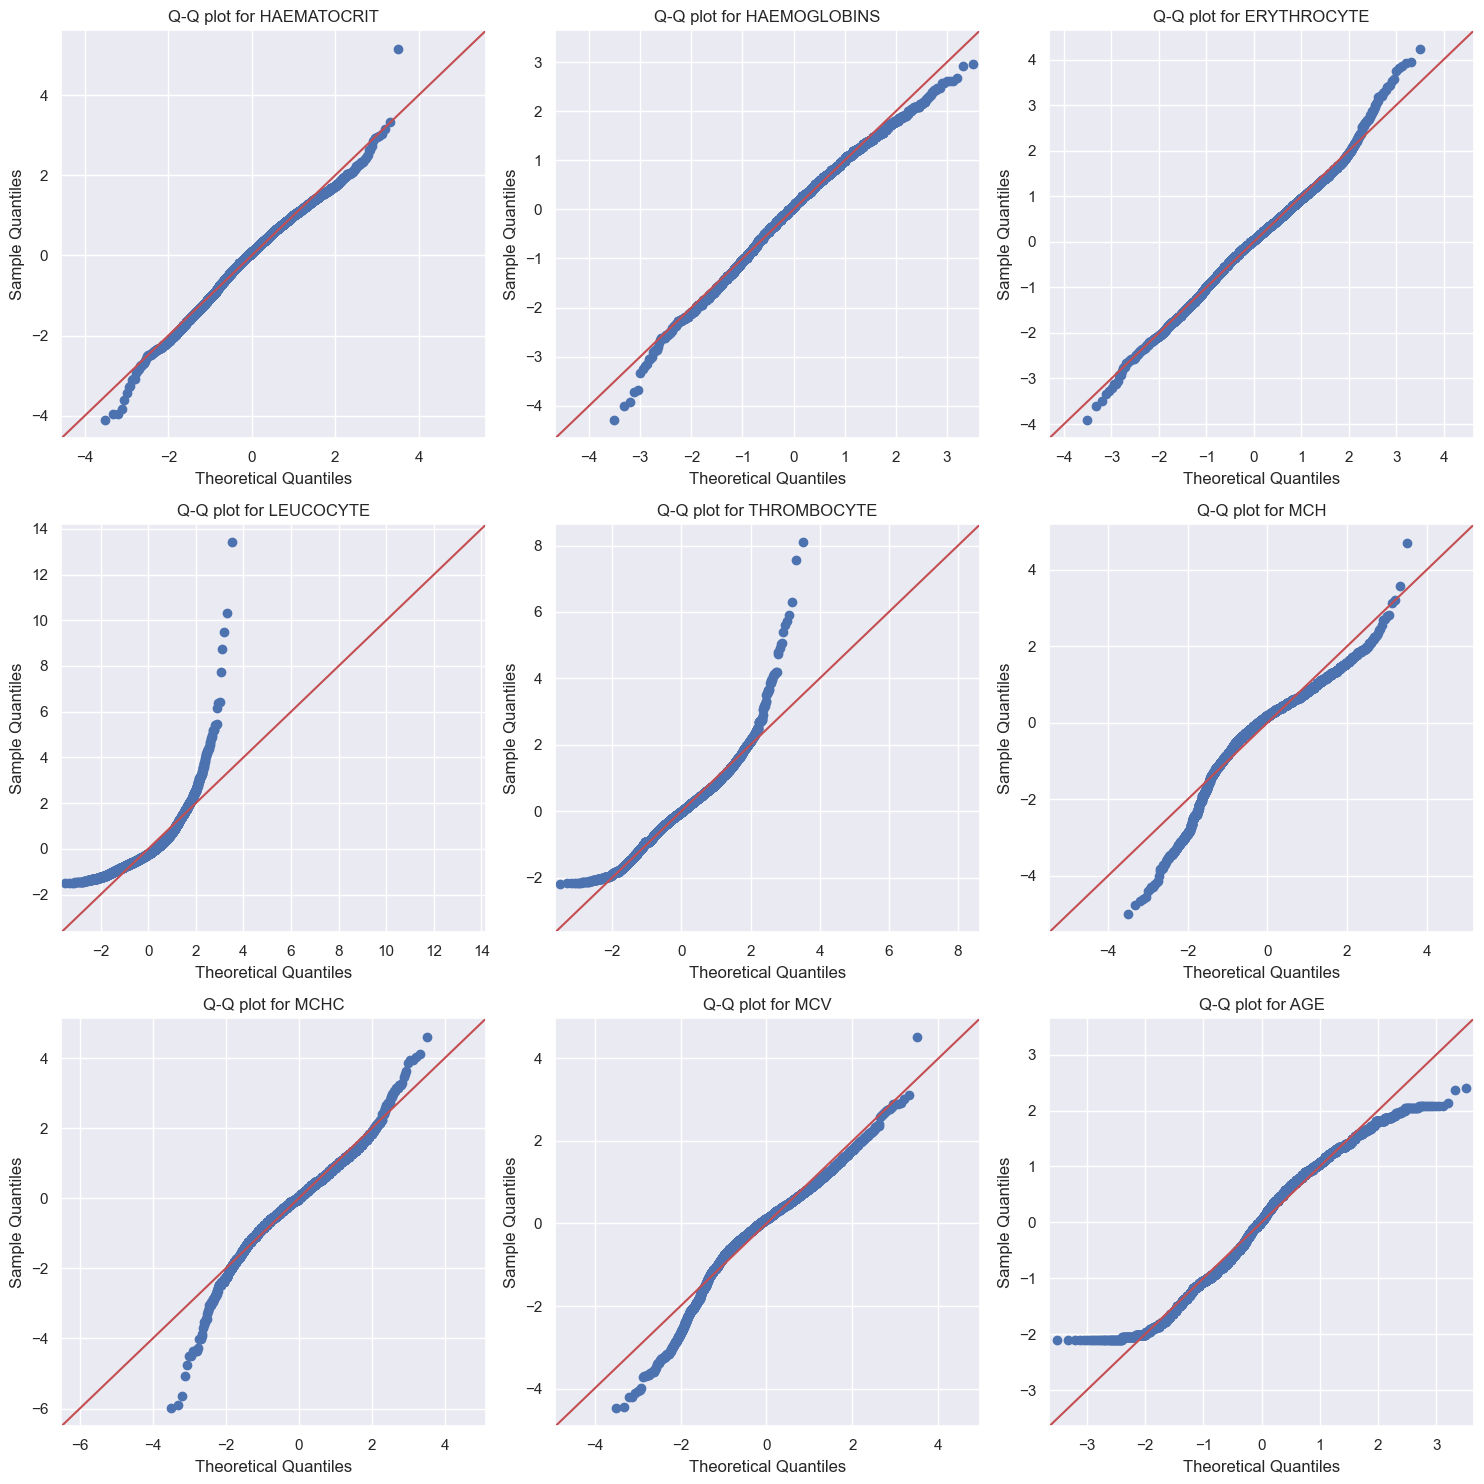

                 Statistic        p-value
HAEMATOCRIT      70.846333   4.129659e-16
HAEMOGLOBINS     72.505472   1.801511e-16
ERYTHROCYTE      50.636894   1.010039e-11
LEUCOCYTE     63461.523424   0.000000e+00
THROMBOCYTE    3364.988832   0.000000e+00
MCH            2292.628795   0.000000e+00
MCHC           1366.448760  1.902926e-297
MCV            1079.133683  4.667649e-235
AGE             141.057522   2.342870e-31


In [14]:
# Assume df_robust is your DataFrame with robust scaling applied to the necessary columns
numeric_cols = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

# Initialize a dictionary to store test results
normality_results = {}

# Determine the grid size for subplots
n_cols = 3  # Number of columns in the grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Calculate rows needed, rounded up

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each column to plot
for i, column in enumerate(numeric_cols):
    # Perform Jarque-Bera test
    stat, p = jarque_bera(data[column])
    normality_results[column] = {'Statistic': stat, 'p-value': p}

    # Plot Q-Q plot in the respective subplot
    sm.qqplot(data[column], line='45', fit=True, ax=axes[i])
    axes[i].set_title(f'Q-Q plot for {column}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Hide any unused subplots if the number of plots isn't a perfect fit for the grid
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

# Show the plot grid
plt.show()
# Convert results to a DataFrame for better visualization
normality_test_df = pd.DataFrame(normality_results).T  # Transpose to have columns as headers
print(normality_test_df)

As can be seen above, all variables are not normalized so we need normalization.

Solve long tail issues:

In [15]:
# # Log Transformation (add 1 to shift all values away from zero)
# data['LEUCOCYTE_log'] = np.log1p(data['LEUCOCYTE'])

# # Winsorizing the data (limiting extreme values to the 95th percentile)
# data['LEUCOCYTE_winsorized'] = mstats.winsorize(data['LEUCOCYTE'], limits=[0, 0.10])

In [16]:
# Log Transformation (add 1 to shift all values away from zero)
data['LEUCOCYTE'] = np.log1p(data['LEUCOCYTE'])
# Winsorizing the data (limiting extreme values to the 95th percentile)
data['LEUCOCYTE'] = mstats.winsorize(data['LEUCOCYTE'], limits=[0, 0.10])

In [17]:
# Log Transformation (add 1 to shift all values away from zero)
data['THROMBOCYTE'] = np.log1p(data['THROMBOCYTE'])
# Winsorizing the data (limiting extreme values to the 95th percentile)
data['THROMBOCYTE'] = mstats.winsorize(data['THROMBOCYTE'], limits=[0, 0.05])

In [18]:
data

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
0            35.1          11.8         4.65   1.987874     5.739793  25.4   
1            43.5          14.8         5.39   2.617396     5.814131  27.5   
2            33.5          11.3         4.74   2.653242     5.723585  23.8   
3            39.1          13.7         4.98   2.442347     5.905362  27.5   
4            30.9           9.9         4.23   2.760010     5.811141  23.4   
...           ...           ...          ...        ...          ...   ...   
4407         32.8          10.4         3.49   2.208274     4.290459  29.8   
4408         33.7          10.8         3.67   2.041220     4.262680  29.4   
4409         33.2          11.2         3.47   2.104134     5.463832  32.3   
4410         31.5          10.4         3.15   2.312535     5.236442  33.0   
4411         33.5          10.9         3.44   1.916923     5.620401  31.7   

      MCHC    MCV   AGE SEX  SOURCE  
0     33.6   75.5   1.0   F       0  
1     34.0   80.7   1.0   F       0  
2     33.7   70.7   1.0   F       0  
3     35.0   78.5   1.0   F       0  
4     32.0   73.0   1.0   M       0  
...    ...    ...   ...  ..     ...  
4407  31.7   94.0  92.0   F       1  
4408  32.0   91.8  92.0   F       1  
4409  33.7   95.7  93.0   F       0  
4410  33.0  100.0  98.0   F       1  
4411  32.5   97.4  99.0   F       0  

[4412 rows x 11 columns]

In [19]:
# Select numeric columns (excluding categorical columns like 'SEX' and 'SOURCE')
# numeric_cols = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE_winsorized', 'THROMBOCYTE_winsorized', 'MCH', 'MCHC', 'MCV', 'AGE']
numeric_cols = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

# # Min-Max Scaling
# min_max_scaler = MinMaxScaler()
# df_min_max = data.copy()
# df_min_max[numeric_cols] = min_max_scaler.fit_transform(data[numeric_cols])

# Z-score Normalization
standard_scaler = StandardScaler()
df_standard = data.copy()
df_standard[numeric_cols] = standard_scaler.fit_transform(data[numeric_cols])

# Robust Scaling
robust_scaler = RobustScaler()
df_robust = data.copy()
df_robust[numeric_cols] = robust_scaler.fit_transform(data[numeric_cols])

In [20]:
numeric_cols

['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'MCH', 'MCHC', 'MCV', 'AGE']

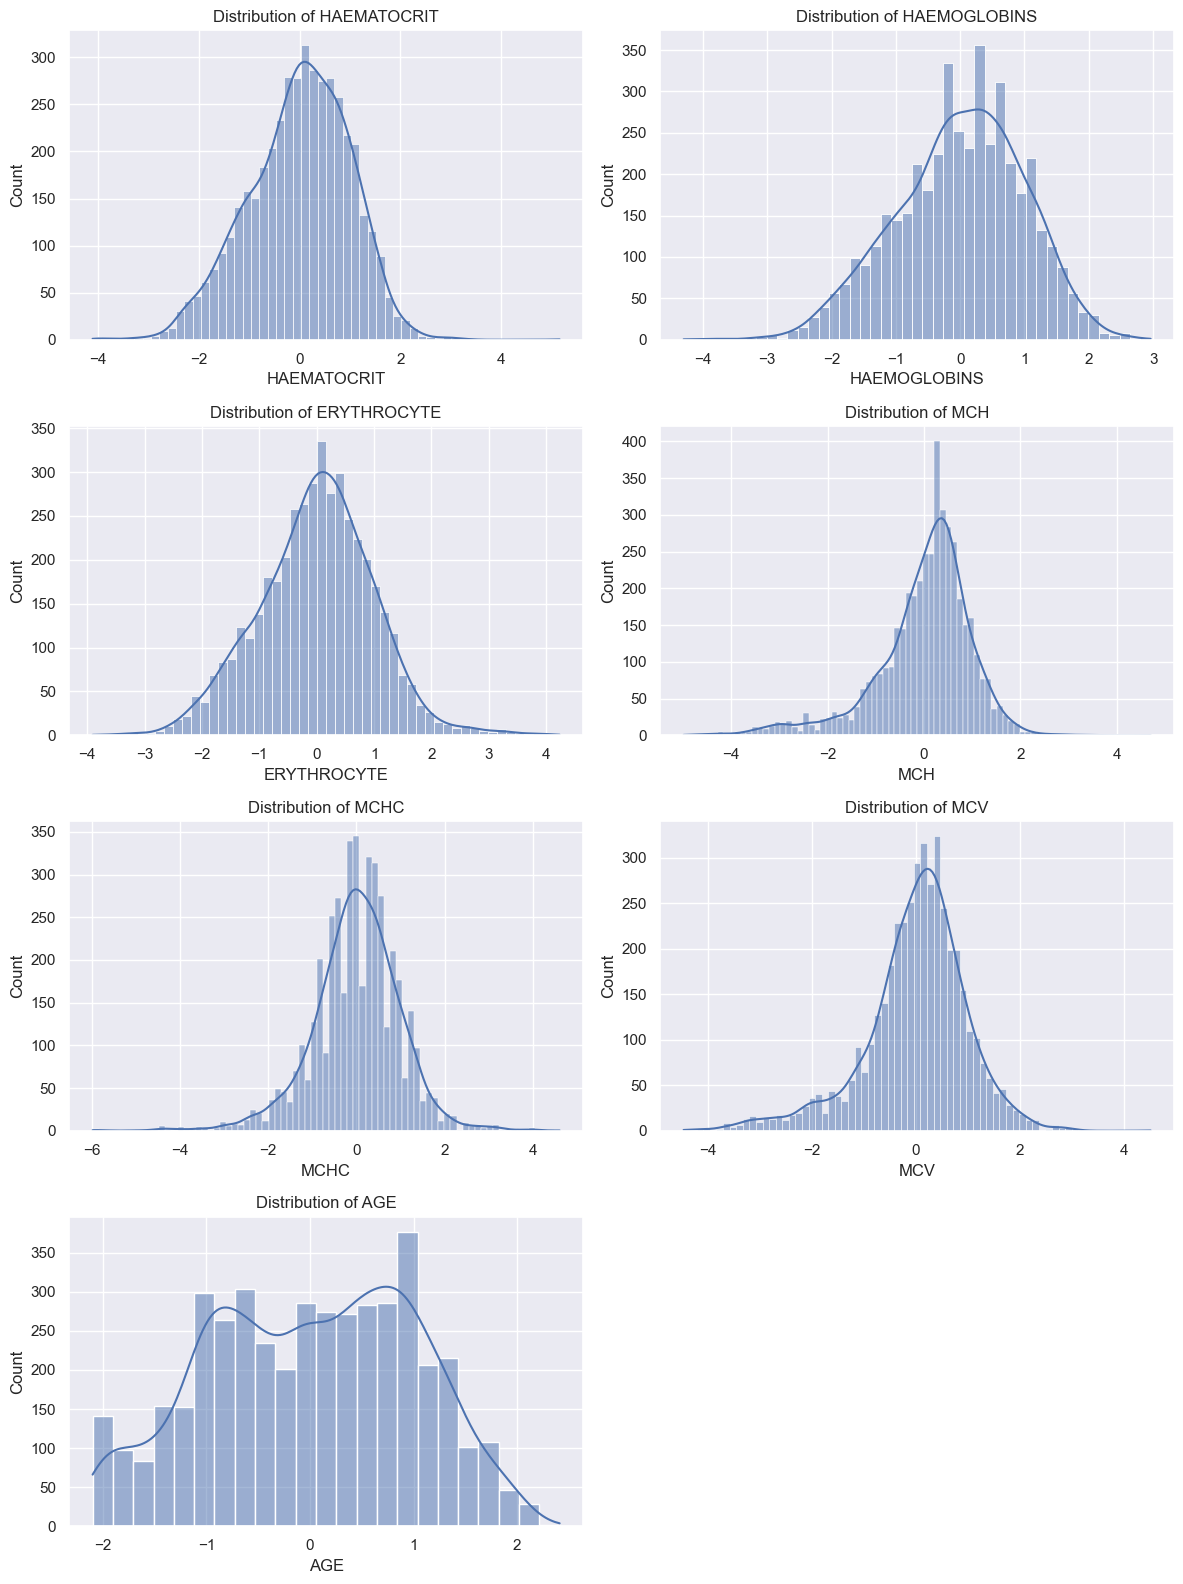

In [21]:
# Distribution of variables
num_vars = len(numeric_cols)

# Calculate the number of rows needed in the subplot grid (2 columns grid here for more horizontal space)
num_rows = (num_vars + 1) // 2

plt.figure(figsize=(12, num_rows * 4))  # Adjust the figure size based on the number of rows
for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, 2, i + 1)  # 2 columns
    sns.histplot(df_standard[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

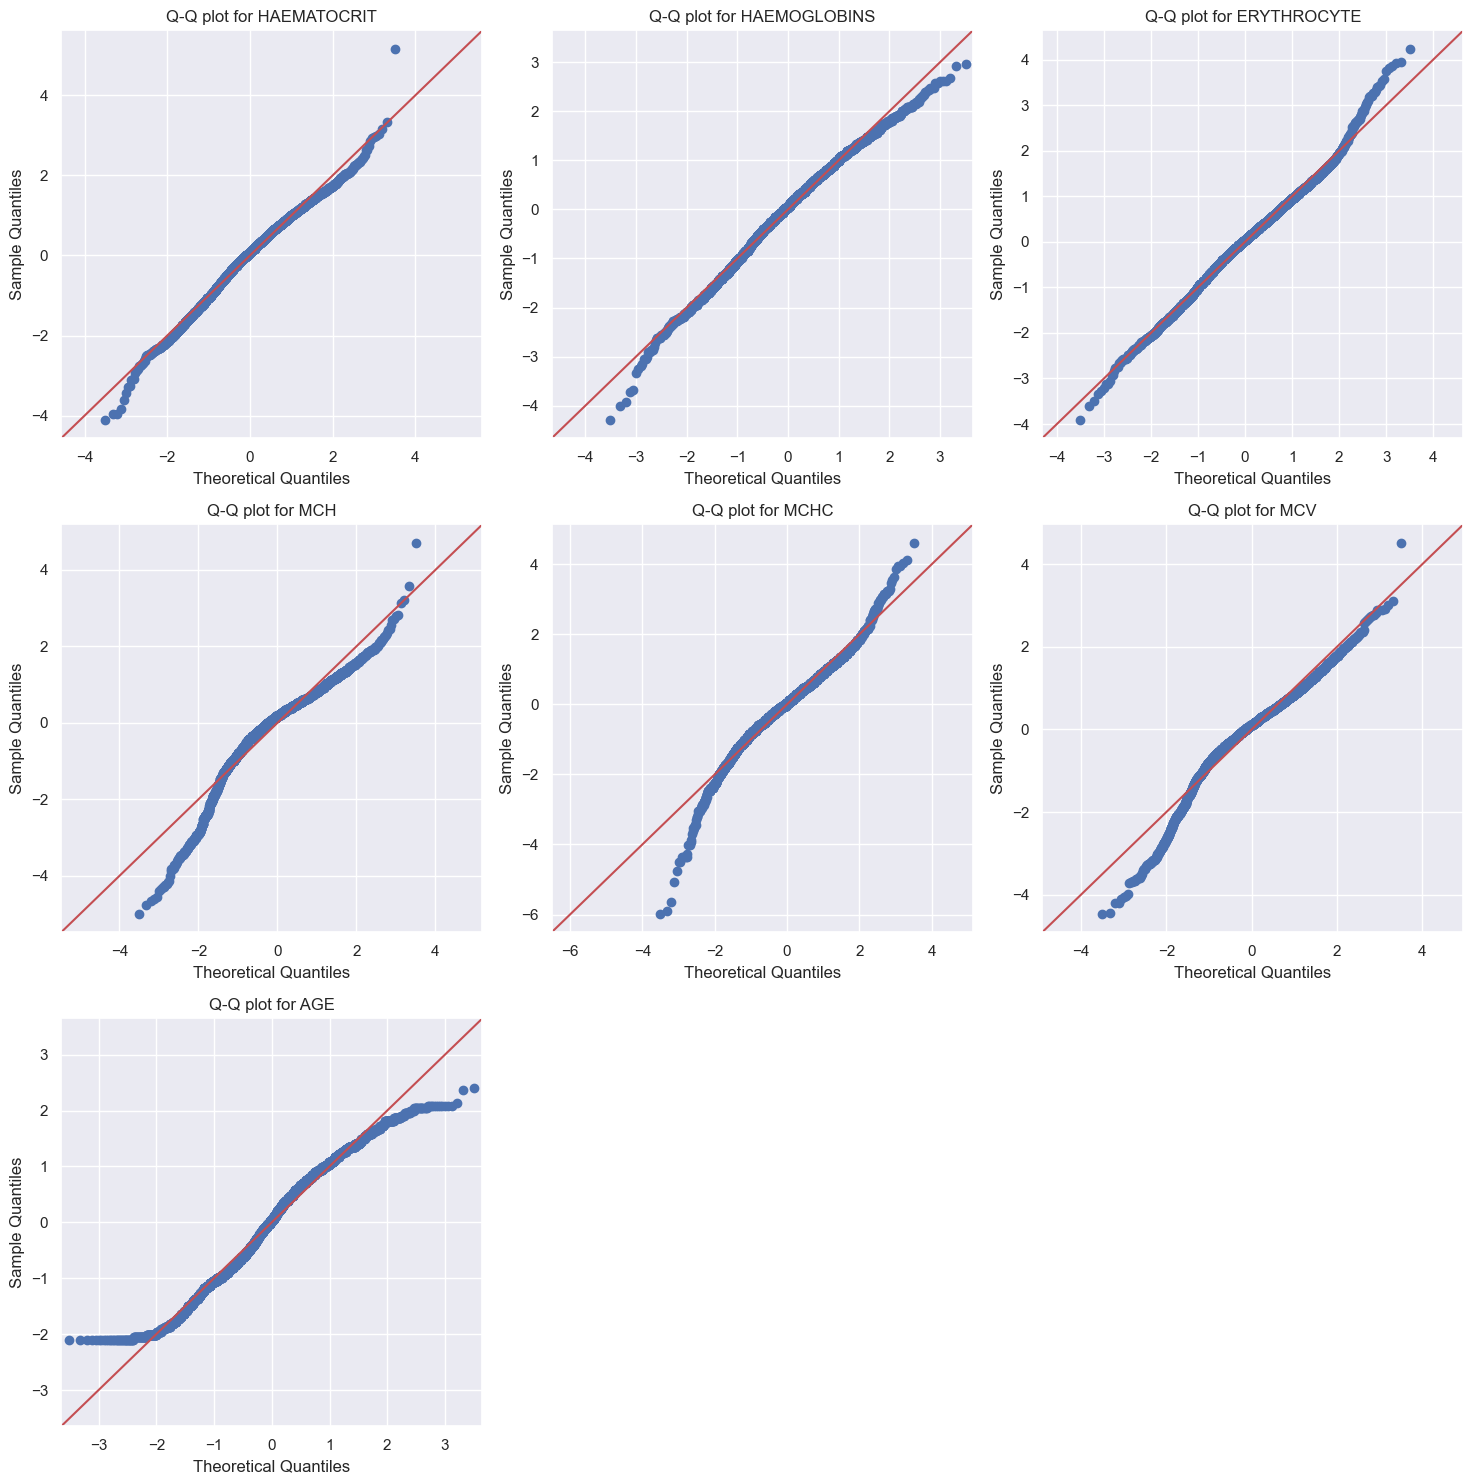

                Statistic        p-value
HAEMATOCRIT     70.846333   4.129659e-16
HAEMOGLOBINS    72.505472   1.801511e-16
ERYTHROCYTE     50.636894   1.010039e-11
MCH           2292.628795   0.000000e+00
MCHC          1366.448760  1.902926e-297
MCV           1079.133683  4.667649e-235
AGE            141.057522   2.342870e-31


In [22]:
# Initialize a dictionary to store test results
normality_results = {}

# Determine the grid size for subplots
n_cols = 3  # Number of columns in the grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Calculate rows needed, rounded up

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each column to plot
for i, column in enumerate(numeric_cols):
    # Perform Jarque-Bera test
    stat, p = jarque_bera(df_standard[column])
    normality_results[column] = {'Statistic': stat, 'p-value': p}

    # Plot Q-Q plot in the respective subplot
    sm.qqplot(df_standard[column], line='45', fit=True, ax=axes[i])
    axes[i].set_title(f'Q-Q plot for {column}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Hide any unused subplots if the number of plots isn't a perfect fit for the grid
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

# Show the plot grid
plt.show()

# Convert results to a DataFrame for better visualization
normality_test_df = pd.DataFrame(normality_results).T  # Transpose to have columns as headers

print(normality_test_df)

### Univariate Analysis
Exploring each feature of the dataset

#### Target Variable
* **name:** 'SOURCE'
* **classes:** {'in': 1, 'out': 0}

In [23]:
fig = px.histogram(data, x='SOURCE')
fig.show()

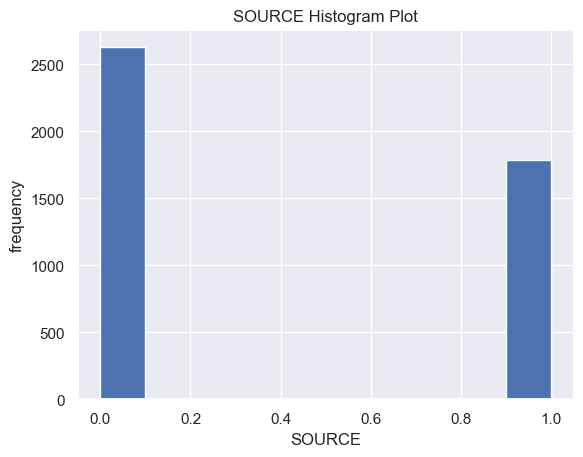

In [24]:
fig, ax = plt.subplots()
ax.hist(
    data.loc[:, 'SOURCE'], 
);
ax.set(
    xlabel='SOURCE', 
    ylabel='frequency', 
    title='SOURCE Histogram Plot'
);
# ax.legend(
#     loc='upper right', 
#     frameon=True,
# );


# plt.hist(data.loc[:, 'SOURCE']);

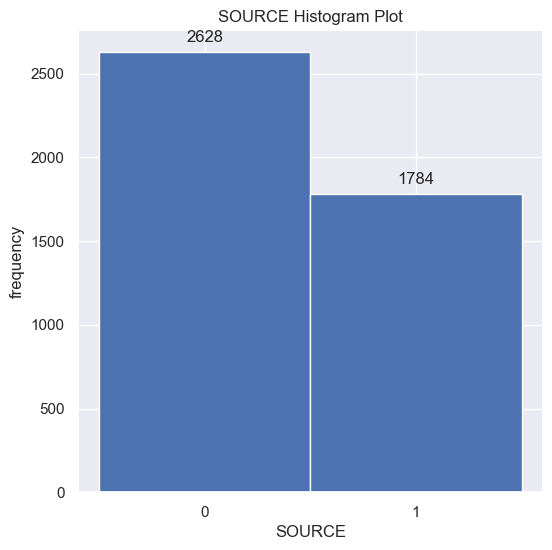

In [25]:
# Create the histogram plot
fig, ax = plt.subplots(figsize=(6,6))
# Set bins such that 0 and 1 are clearly separated
bins = [-0.5, 0.5, 1.5]
counts, _, patches = ax.hist(
    data['SOURCE'], 
    bins=bins, 
    label='cos(x)', align='mid'
)

# Annotate counts above each bar
for count, patch in zip(counts, patches):
    ax.annotate(
        str(int(count)), 
        xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), 
        xytext=(0, 5), 
        textcoords='offset points', 
        ha='center',
        va='bottom'
    )

# Set the axis labels and title
ax.set_xlabel('SOURCE')
ax.set_ylabel('frequency')
ax.set_title('SOURCE Histogram Plot')

# Set x-ticks to only show 0 and 1
ax.set_xticks([0, 1])

# Show the plot

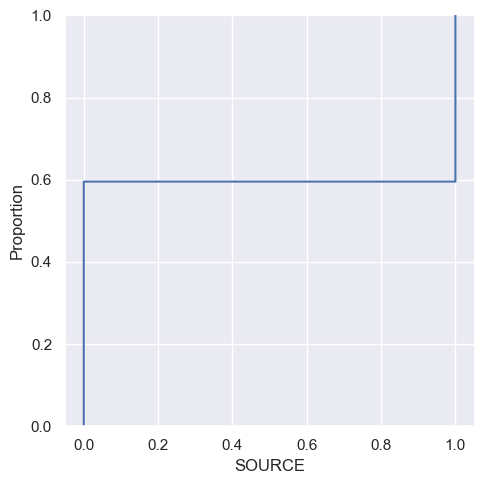

In [26]:
sns.displot(data['SOURCE'], kind='ecdf', stat='proportion')

* The proportion of classes is about 60:40 which is only mildy imbalanced and won't greatly bias the classification

### Numerical Features

* HAEMATOCRIT
* HAEMOGLOBINS
* ERYTHROCYTE
* LEUCOCYTE
* THROMBOCYTE
* MCH
* MCHC
* MCV
* AGE

In [27]:
data[num_feats].describe()

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE    LEUCOCYTE  THROMBOCYTE  \
count  4412.000000   4412.000000  4412.000000  4412.000000  4412.000000   
mean     38.197688     12.741727     4.541260     2.144123     5.419548   
std       5.974784      2.079903     0.784091     0.399456     0.560622   
min      13.700000      3.800000     1.480000     0.741937     2.197225   
25%      34.375000     11.400000     4.040000     1.898348     5.241747   
50%      38.600000     12.900000     4.570000     2.151762     5.549076   
75%      42.500000     14.200000     5.050000     2.424803     5.774552   
max      69.000000     18.900000     7.860000     2.760010     6.086775   

               MCH         MCHC          MCV          AGE  
count  4412.000000  4412.000000  4412.000000  4412.000000  
mean     28.234701    33.343042    84.612942    46.626473  
std       2.672639     1.228664     6.859101    21.731218  
min      14.900000    26.000000    54.000000     1.000000  
25%      27.200000    32.700000    81.500000    29.000000  
50%      28.700000    33.400000    85.400000    47.000000  
75%      29.800000    34.100000    88.700000    64.000000  
max      40.800000    39.000000   115.600000    99.000000

Based on the descriptions of each of the feature variables, a few peculiar values are in:
* **LEUCOCYTE** - max value is much higher than the mean value
* **THROMBOCYTE** - max and min values are very dispersed

In [28]:
for column in num_feats:
    # Clean and convert data
    clean_data = data[column].dropna()  # Drop NaN values
    clean_data = pd.to_numeric(clean_data, errors='coerce')  # Coerce errors turns any remaining non-numeric values to NaN
    clean_data = clean_data.dropna()  # Drop any new NaNs that were introduced

    # Check if clean_data is empty
    if clean_data.empty:
        print(f"Skipping {column} due to insufficient data after cleaning.")
        continue
    
    fig = make_subplots(rows=1, cols=2)
    
    # Box plot
    fig.add_trace(
        go.Box(y=clean_data, name=column),
        row=1, col=1
    )
    
    # KDE plot
    hist_data = [clean_data]
    group_labels = [column]
    distplot = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
    for trace in distplot.data:
        fig.add_trace(trace, row=1, col=2)
    
    fig.update_layout(title=f"Analysis of {column}")
    fig.show()

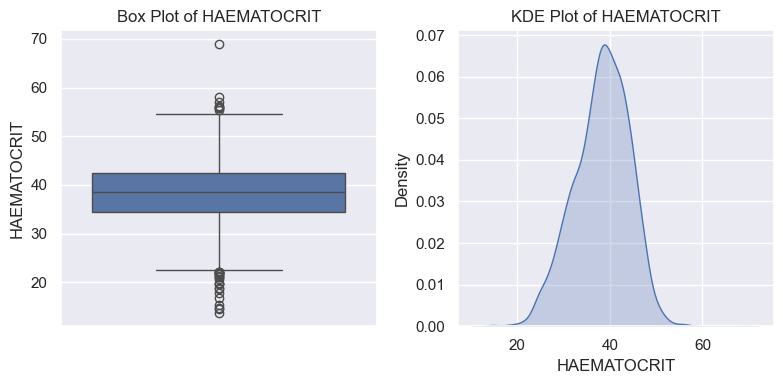

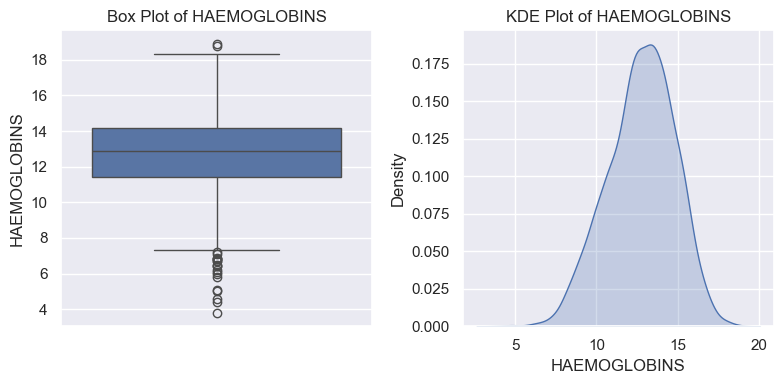

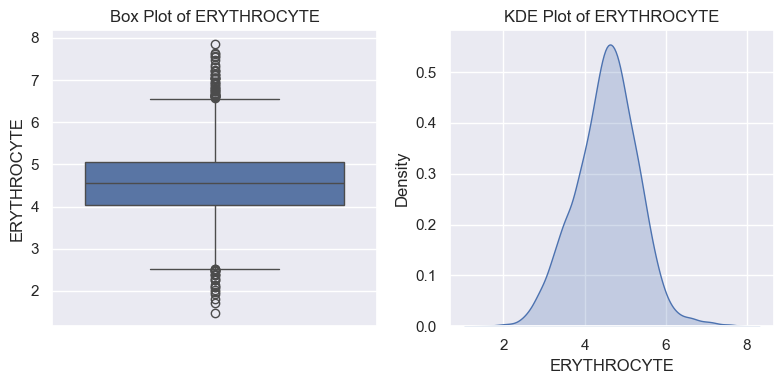

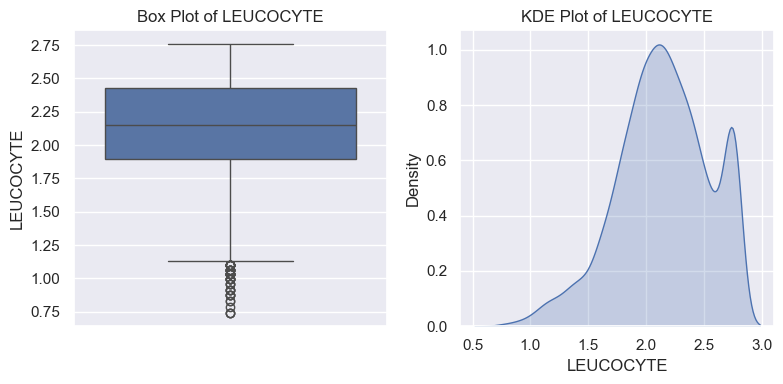

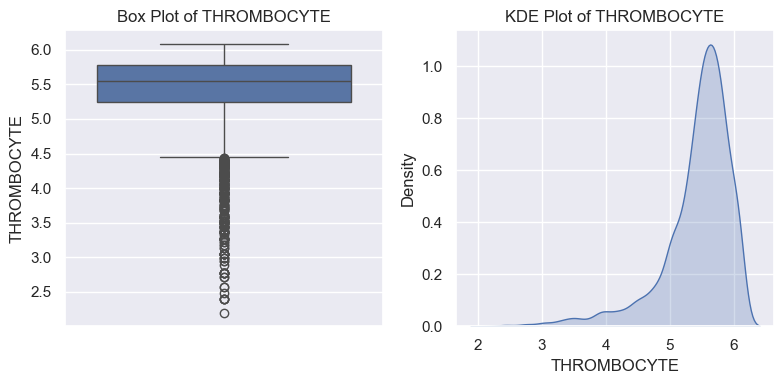

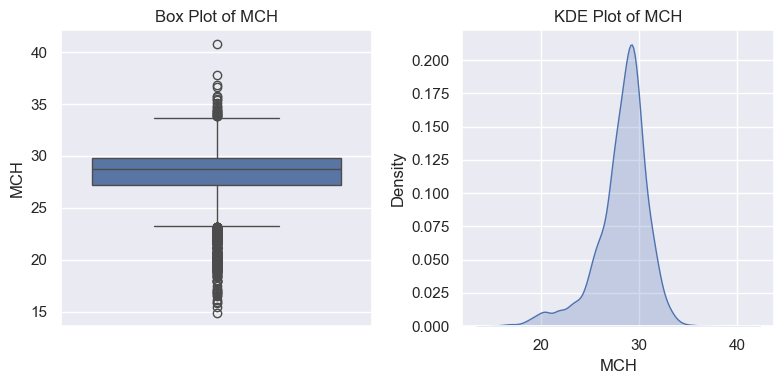

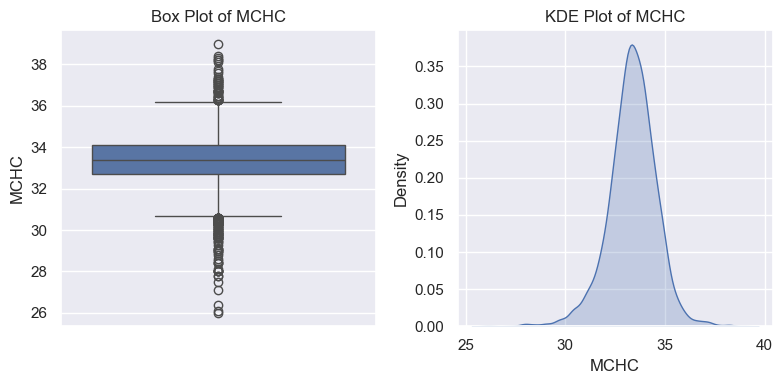

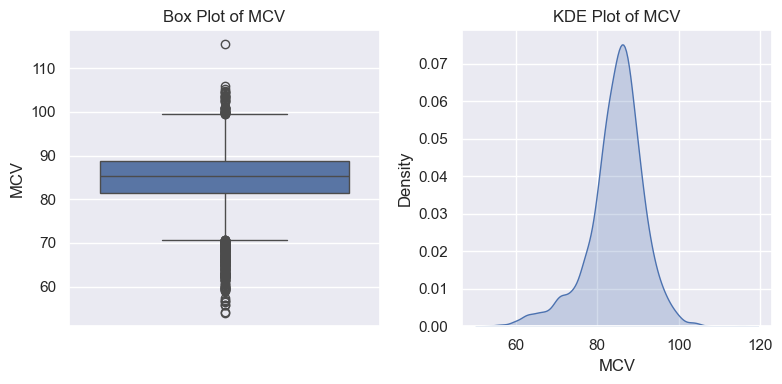

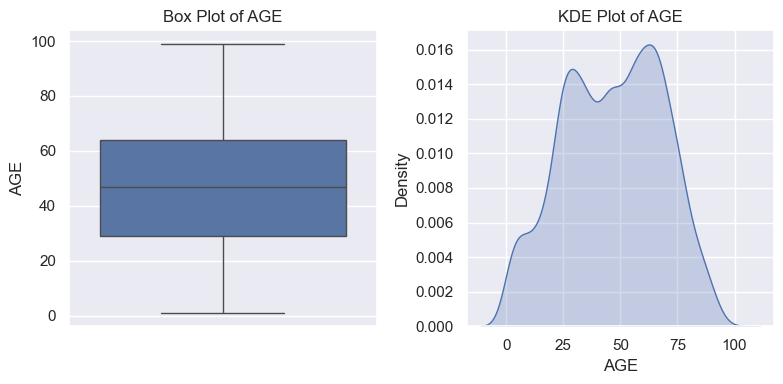

In [29]:
for column in num_feats:
    # Set up a subplot grid with 1 row and 2 columns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
    # Box plot on the first subplot
    sns.boxplot(y=data[column], ax=axes[0])
    axes[0].set_title(f'Box Plot of {column}')
    axes[0].set_ylabel(column)
    
    # KDE plot on the second subplot
    sns.kdeplot(data[column], ax=axes[1], fill=True)
    axes[1].set_title(f'KDE Plot of {column}')
    axes[1].set_xlabel(column)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [30]:
data.loc[data['LEUCOCYTE']==76.6]

Empty DataFrame
Columns: [HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, LEUCOCYTE, THROMBOCYTE, MCH, MCHC, MCV, AGE, SEX, SOURCE]
Index: []

In [31]:
data.loc[data['THROMBOCYTE']==1183]

Empty DataFrame
Columns: [HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, LEUCOCYTE, THROMBOCYTE, MCH, MCHC, MCV, AGE, SEX, SOURCE]
Index: []

* Most of the features follow an almost normal distribution with the exception of the LEUCOCYTE, THROMBOCYTE, and and AGE features.
* After inspecting the extreme values in 'LEUCOCYTE' and 'THROMBOCYTE' I have decided to keep them as the other values seem fine as this extreme values could be attributed to the reason they were visiting the hospital.

### Categorical Variable:

* **name**: SEX
* **classes**: F, M 

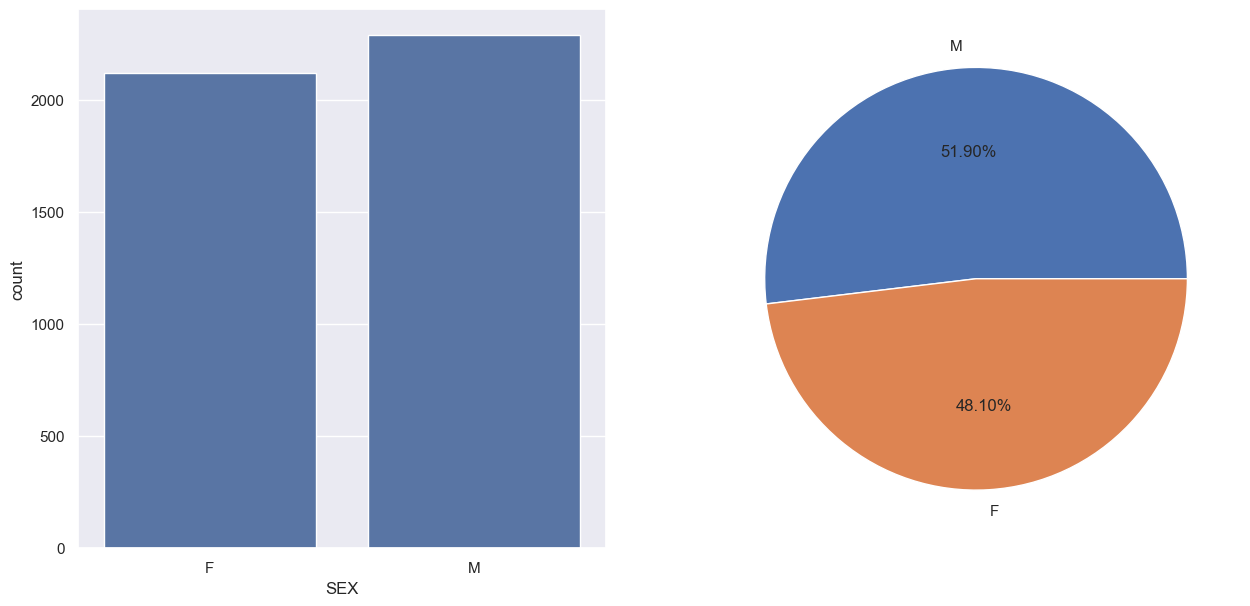

In [32]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.countplot(data, x='SEX', ax=ax[0])
plt.pie(data['SEX'].value_counts(), autopct='%0.2f%%', labels=['M', 'F'])
plt.show()

In [33]:
data['SEX'].value_counts()

M    2290
F    2122
Name: SEX, dtype: int64

### Bivariate Analysis:

In [34]:
data

HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
0            35.1          11.8         4.65   1.987874     5.739793  25.4   
1            43.5          14.8         5.39   2.617396     5.814131  27.5   
2            33.5          11.3         4.74   2.653242     5.723585  23.8   
3            39.1          13.7         4.98   2.442347     5.905362  27.5   
4            30.9           9.9         4.23   2.760010     5.811141  23.4   
...           ...           ...          ...        ...          ...   ...   
4407         32.8          10.4         3.49   2.208274     4.290459  29.8   
4408         33.7          10.8         3.67   2.041220     4.262680  29.4   
4409         33.2          11.2         3.47   2.104134     5.463832  32.3   
4410         31.5          10.4         3.15   2.312535     5.236442  33.0   
4411         33.5          10.9         3.44   1.916923     5.620401  31.7   

      MCHC    MCV   AGE SEX  SOURCE  
0     33.6   75.5   1.0   F       0  
1     34.0   80.7   1.0   F       0  
2     33.7   70.7   1.0   F       0  
3     35.0   78.5   1.0   F       0  
4     32.0   73.0   1.0   M       0  
...    ...    ...   ...  ..     ...  
4407  31.7   94.0  92.0   F       1  
4408  32.0   91.8  92.0   F       1  
4409  33.7   95.7  93.0   F       0  
4410  33.0  100.0  98.0   F       1  
4411  32.5   97.4  99.0   F       0  

[4412 rows x 11 columns]

In [35]:
num_feats

['HAEMATOCRIT',
 'HAEMOGLOBINS',
 'ERYTHROCYTE',
 'LEUCOCYTE',
 'THROMBOCYTE',
 'MCH',
 'MCHC',
 'MCV',
 'AGE']

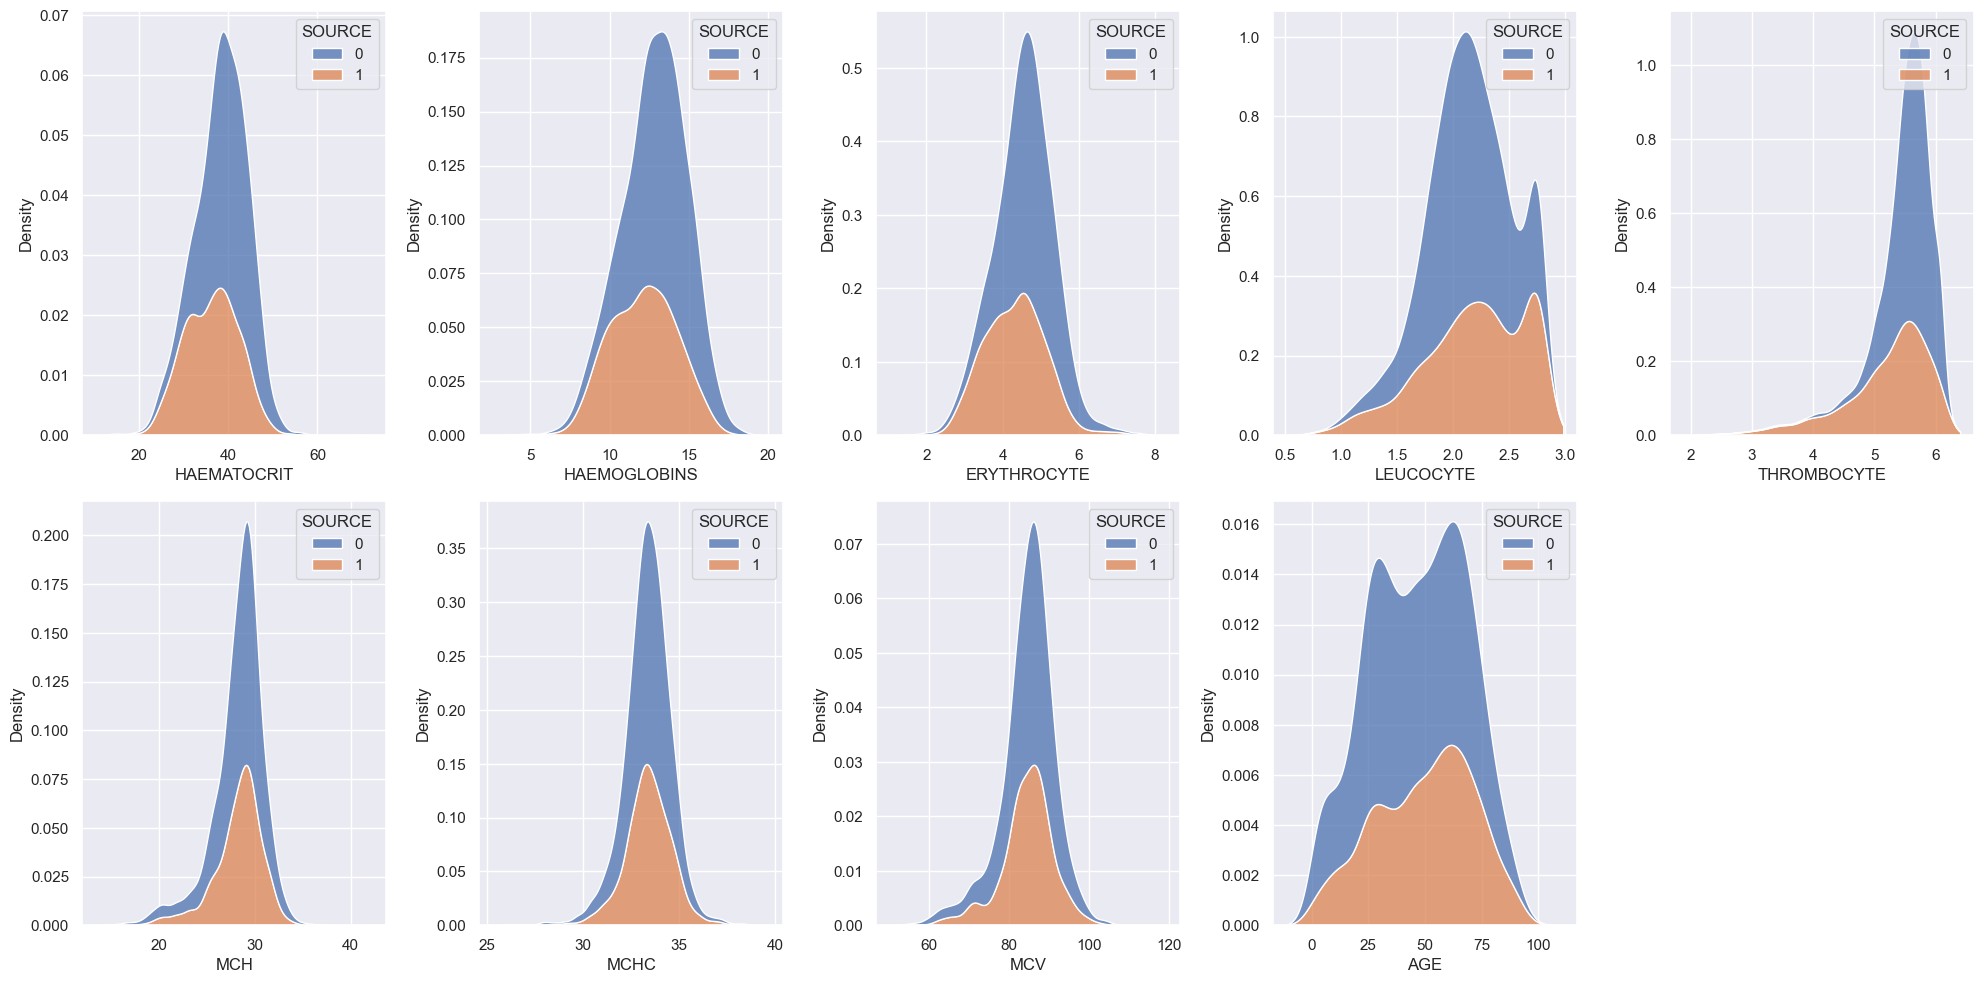

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(20,10))
axes = [ax for rows in axs for ax in rows]
for idx, feat in enumerate(data[num_feats]):
    plot = sns.kdeplot(data=data, x=feat, hue='SOURCE', multiple='stack', ax=axes[idx])

# Hide unused subplots
for i in range(len(num_feats), len(axes)):
    axes[i].axis('off')  # Turn off the axis for unused subplots

plt.tight_layout()
plt.show()

In [37]:
# numeric_features = [feat for feat in data.columns if feat not in ['SEX', 'SOURCE']]

# fig, axs = plt.subplots(5, 2, figsize=(14, 22))
# plt.subplots_adjust(hspace=0.3, wspace=0.3)
# axes = [ax for rows in axs for ax in rows]

# # Assuming 'num_feats' contains the list of numeric features you want to plot
# for idx, feat in enumerate(numeric_features):
#     print(feat)
#     sns.kdeplot(data=data, x=feat, hue='SOURCE', multiple='stack', ax=axes[idx])

# # # Plot 'SEX' with a count plot on the designated subplot axis
# # sns.countplot(data=data, x='SEX', hue='SOURCE', ax=axes[7]) 

* The features HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, THROMBOCYTE, AGE show quite a difference in their distributions between the 'in' and 'out' patients, indicating that they serve as much better differentiators of the target variables than the rest.

* The categorical variables only tell us that there is a slightly higher proportion of males in in-patients than out-patients.

* There is a slightly higher older population that are admitted as in-patients but that would be expected and is not of much an insight for now.

---
## Statistical Tests

### 1. Feature Selection

Check variable independence - correlation analysis: calculate the Pearson correlation coefficient for all pairs of continuous variables.

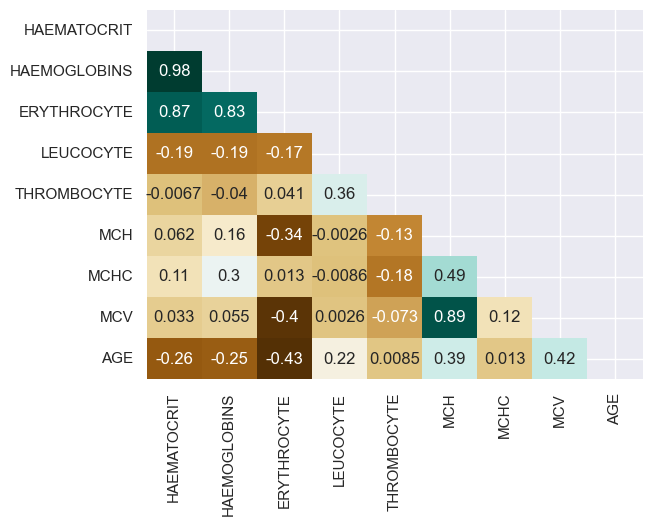

In [38]:
corr = data[num_feats].corr(method='spearman')
triu_corr = np.triu(corr)
sns.heatmap(corr, annot=True, mask=triu_corr, cmap='BrBG', cbar=False)
plt.show()

* From the pairplots and correlation matrix we can see a high multicollinarity between  'HAEMATOCRIT' and 'HAEMOGLOBINS'(0.98) and  'MCH' and 'MCHC' (0.89). Even 'HAEMATOCRIT' and 'ERYTHROCYTE' (0.87), 'HAEMOGLOBINS' and  'ERYTHROCYTE' (0.83) have a relatively high level of correlation that can lead to overfitting of the model and lead to poor generalization performance on unseen data.

In [39]:
continuous_vars = data.select_dtypes(include=[float, int])
correlation_matrix = continuous_vars.corr()
print(correlation_matrix)

              HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE  \
HAEMATOCRIT      1.000000      0.973267     0.864989  -0.177564     0.014739   
HAEMOGLOBINS     0.973267      1.000000     0.818013  -0.174084    -0.026076   
ERYTHROCYTE      0.864989      0.818013     1.000000  -0.158662     0.025459   
LEUCOCYTE       -0.177564     -0.174084    -0.158662   1.000000     0.357672   
THROMBOCYTE      0.014739     -0.026076     0.025459   0.357672     1.000000   
MCH              0.083714      0.203248    -0.383666  -0.005727    -0.107961   
MCHC             0.108098      0.314159    -0.048313  -0.010509    -0.196502   
MCV              0.054948      0.105379    -0.436041  -0.000342    -0.041375   
AGE             -0.254799     -0.239480    -0.412858   0.226352     0.024762   
SOURCE          -0.271190     -0.255793    -0.232001   0.076162    -0.319679   

                   MCH      MCHC       MCV       AGE    SOURCE  
HAEMATOCRIT   0.083714  0.108098  0.054948 -0.254799 -

Strong Positive Correlations:
HAEMATOCRIT and HAEMOGLOBINS: A correlation of 0.973. 0.973 indicates almost a linear relationship. This is expected since hematocrit is the volume percentage of red blood cells in blood, and hemoglobin is a protein in those cells.
MCH and MCV: A correlation of 0.932. 0.932 suggests that the mean corpuscular hemoglobin (MCH, the average mass of hemoglobin per red blood cell) and the mean corpuscular volume (MCV, the average volume of a red blood cell) are closely linked, which makes sense as both describe properties of red blood cells.
Strong Negative Correlations:


ERYTHROCYTE and MCV: The −0.436. −0.436 correlation indicates that as the erythrocyte count increases, the mean corpuscular volume tends to decrease. This could suggest that higher red blood cell counts are associated with smaller sized cells, potentially pointing to certain microcytic anemias.
AGE and ERYTHROCYTE: A correlation of −0.413. −0.413 may imply that erythrocyte counts tend to decrease with age, which could be relevant in clinical settings.
Moderate to Low Correlations:
LEUCOCYTE and THROMBOCYTE: A correlation of 0.283. 0.283 might suggest a moderate association, indicating possible simultaneous responses to certain conditions like infections or inflammations.
AGE and MCV: The positive correlation of 0.395. 0.395 could indicate changes in red blood cell size with aging.

In [40]:
# Chi-Square Test of Independence for SEX and SOURCE
contingency_table = pd.crosstab(data['SEX'], data['SOURCE'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 11.626002500279858, p-value: 0.0006503617798734924


Chi-Square Statistic: The Chi-Square statistic of 11.626 suggests that there is a disparity between the observed counts in the categories of SEX and SOURCE and what would be expected if they were independent of each other. A higher Chi-Square value generally indicates a stronger divergence from the null hypothesis of independence.  
p-value: The p-value is a measure of the probability that the observed data (or something more extreme) would occur if the null hypothesis (in this case, the hypothesis that there is no association between SEX and SOURCE) were true. The p-value is 0.0006503617798734924, which is quite low.  

Conclusion:  
Since the p-value is less than 0.05 (a common threshold in statistical testing), we can reject the null hypothesis. This indicates that there is a statistically significant association between the variables SEX and SOURCE.  
In simpler terms, the gender (SEX) of the subjects in our dataset appears to be related to the category of SOURCE. This could mean that whether the SOURCE is "in" or "out" depends to some extent on the gender, or vice versa.  

In [41]:
# Chi-Square Test of Independence for SEX and SOURCE
contingency_table = pd.crosstab(data['HAEMATOCRIT'], data['HAEMOGLOBINS'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 182515.94615897577, p-value: 0.0


The p-value is very close to zero (0.0), which indicates strong evidence against the null hypothesis. It means that there is a significant association between 'HAEMATOCRIT' and 'HAEMOGLOBINS'.  

The Chi-Square Statistic is considerably high, suggesting a strong association between the two variables.  

In [42]:
# Chi-Square Test of Independence for SEX and SOURCE
contingency_table = pd.crosstab(data['MCH'], data['MCV'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 271188.93780701736, p-value: 0.0


The p-value is very close to zero (0.0), which indicates strong evidence against the null hypothesis. It means that there is a significant association between 'MCH' and 'MCV'.  

The Chi-Square Statistic is considerably high, suggesting a strong association between the two variables.  

## Drop values

In [43]:
data = df_standard.drop(columns=['HAEMATOCRIT', 'MCH'])
features = [col for col in data.columns if col != 'SOURCE']
num_feats = [numf for numf in features if data[numf].dtype != object]
cat_feats = [catf for catf in features if data[catf].dtype == object]

### 2. Does the inclusion of certain variables (e.g., AGE, SEX, and HAEMOGLOBINS) significantly improve the model's ability to explain the variation in the dependent variable (SOURCE)?"

In [44]:
# Define the models
model1 = sm.OLS.from_formula("SOURCE ~ 1", data=data) # intercept only 
model2 = sm.OLS.from_formula("SOURCE ~ AGE + SEX + HAEMOGLOBINS", data=data)

# Fit the models
result1 = model1.fit()
result2 = model2.fit()

# Perform the likelihood ratio test
lrt_stat = -2 * (result1.llf - result2.llf)
lrt_pval = stats.chi2.sf(lrt_stat, df=result2.df_model - result1.df_model)

print("Likelihood Ratio Test:")
print("Test Statistic:", lrt_stat)
print("p-value:", lrt_pval)

Likelihood Ratio Test:
Test Statistic: 394.3092084217915
p-value: 3.7826754159527335e-85


The test statistic (394.31) indicates that the alternative model (Model 2) is significantly better than the null model (Model 1) in explaining the variation in the dependent variable (SOURCE).  
The p-value (3.78e-85) is extremely small, which means that the probability of observing the test statistic (or a more extreme value) under the null hypothesis is virtually zero.  
Therefore, we can reject the null hypothesis (Model 1) and conclude that the alternative model (Model 2) is a better fit to the data.  
In other words, the inclusion of the additional variables (AGE, SEX, and HAEMATOCRIT) in the alternative model significantly improves the model's ability to explain the variation in SOURCE. This suggests that these variables are important predictors of SOURCE.

### 3. Does the inclusion of certain variables (e.g., ERYTHROCYTE, LEUCOCYTE, THROMBOCYTE, MCHC and MCV) significantly improve the model's ability to explain the variation in the dependent variable (SOURCE)?"

In [45]:
# Define the models
model1 = sm.OLS.from_formula("SOURCE ~ AGE + SEX + HAEMOGLOBINS", data=data)
model2 = sm.OLS.from_formula("SOURCE ~ AGE + SEX + HAEMOGLOBINS + ERYTHROCYTE + LEUCOCYTE + THROMBOCYTE + MCHC + MCV", data=data)

# Fit the models
result1 = model1.fit()
result2 = model2.fit()

# Perform the likelihood ratio test
lrt_stat = -2 * (result1.llf - result2.llf)
lrt_pval = stats.chi2.sf(lrt_stat, df=result2.df_model - result1.df_model)

print("Likelihood Ratio Test:")
print("Test Statistic:", lrt_stat)
print("p-value:", lrt_pval)

Likelihood Ratio Test:
Test Statistic: 635.1009685422432
p-value: 5.2566584933447596e-135


In [46]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SOURCE   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     137.4
Date:                Thu, 09 May 2024   Prob (F-statistic):           4.42e-85
Time:                        18:02:18   Log-Likelihood:                -2922.8
No. Observations:                4412   AIC:                             5854.
Df Residuals:                    4408   BIC:                             5879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3329      0.011     31.699      0.000       0.312       0.353
SEX[T.M]         0.1378      0.015      9.208      0.000       0.108       0.167
AGE              0.0178      0.007      2.431      0.015       0.003       0.032
HAEMOGLOBINS    -0.1425      0.008    -18.513      0.000      -0.158      -0.127
==============================================================================
Omnibus:                    27946.985   Durbin-Watson:                   0.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.049
Skew:                           0.368   Prob(JB):                    1.06e-111
Kurtosis:                       1.504   Cond. No.                         2.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SOURCE   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     144.6
Date:                Thu, 09 May 2024   Prob (F-statistic):          1.35e-216
Time:                        18:02:18   Log-Likelihood:                -2605.2
No. Observations:                4412   AIC:                             5228.
Df Residuals:                    4403   BIC:                             5286.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.7445      0.068     25.750      0.000       1.612       1.877
SEX[T.M]         0.0890      0.014      6.258      0.000       0.061       0.117
AGE              0.0160      0.008      2.053      0.040       0.001       0.031
HAEMOGLOBINS     0.0274      0.053      0.519      0.604      -0.076       0.131
ERYTHROCYTE     -0.1656      0.055     -2.992      0.003      -0.274      -0.057
LEUCOCYTE        0.1900      0.019     10.214      0.000       0.154       0.227
THROMBOCYTE     -0.3310      0.013    -25.263      0.000      -0.357      -0.305
MCHC            -0.0293      0.014     -2.040      0.041      -0.057      -0.001
MCV             -0.0925      0.028     -3.329      0.001      -0.147      -0.038
==============================================================================
Omnibus:                     1051.379   Durbin-Watson:                   0.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.949
Skew:                           0.382   Prob(JB):                     2.97e-63
Kurtosis:                       2.009   Cond. No.                         75.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value is extremely close to zero, indicating strong evidence against the null hypothesis. It suggests that the more complex model (model2) provides a significantly better fit to the data compared to the simpler model (model1).  
The Test Statistic is relatively high, indicating a substantial difference in fit between the two models.  
In summary, the result suggests that including additional variables in the model significantly improves its ability to explain the variation in the response variable 'SOURCE'.

## ANOVA

Null Hypothesis (H0):
There is no statistically significant difference in the mean haemoglobin level among the different levels of the 'SEX' variable.  
Alternative Hypothesis (H1):
There is a statistically significant difference in the mean haemoglobin level among the different levels of the 'SEX' variable.  

Symbolically:

H0: μ0 = μ1 = ... = μn (where μ represents the population mean for each level of 'SEX')  
H1: At least one population mean is different  
Here, 'μ0', 'μ1', ..., 'μn' represent the population means of haemoglobin level for each level of the 'SEX' variable.  

After conducting the one-way ANOVA test, if the resulting p-value is less than a predetermined significance level (typically α = 0.05), we reject the null hypothesis in favor of the alternative hypothesis, concluding that there is sufficient evidence to suggest that the mean haemoglobin level varies significantly across the different levels of the 'SEX' variable. Conversely, if the p-value is greater than α, we fail to reject the null hypothesis, indicating that there is insufficient evidence to conclude that there are significant differences in haemoglobin levels among the different levels of 'SEX'.

In [48]:
# Perform One-Way ANOVA
f_value, p_value = stats.f_oneway(
    data[data['SEX'] == 'F']['HAEMOGLOBINS'],
    data[data['SEX'] == 'M']['HAEMOGLOBINS']
)

print("F-value:", f_value)
print("P-value:", p_value)

F-value: 462.22783354405004
P-value: 1.3738997495120386e-97


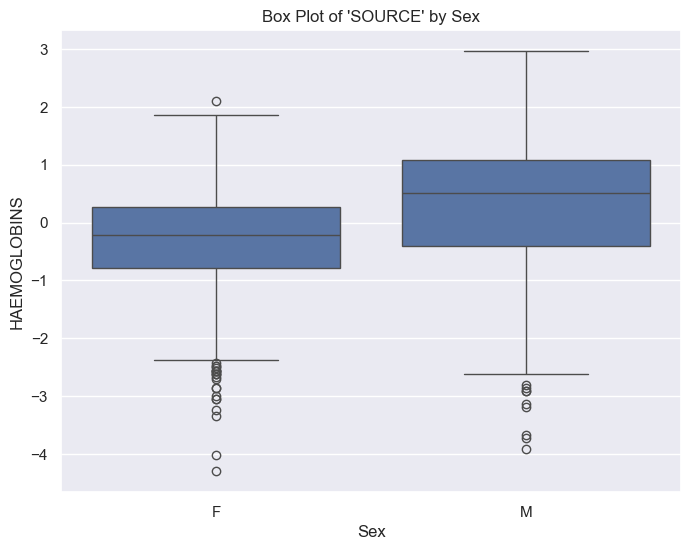

In [49]:
# Filter data by sex
data_female = data[data['SEX'] == 'F']
data_male = data[data['SEX'] == 'M']

# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='SEX', y='HAEMOGLOBINS', data=data)
plt.title("Box Plot of 'SOURCE' by Sex")
plt.xlabel("Sex")
plt.ylabel("HAEMOGLOBINS")
plt.show()

F-value: The F-value is approximately 0.000303. This value indicates the ratio of the variance between the groups (in this case, between females and males) to the variance within the groups. A small F-value suggests that the variation between group means is similar to the variation within each group.  

P-value: The P-value is approximately 0.9861. This value represents the probability of observing the data if the null hypothesis were true. In this context, a high P-value suggests that there is no statistically significant difference in the 'Haemoglobin' variable between females and males. Specifically, with a P-value of 0.9861, we fail to reject the null hypothesis at conventional significance levels (e.g., α = 0.05), indicating that there is insufficient evidence to conclude that there is a difference in 'Haemoglobin' between sexes.  

In summary, based on the results of the one-way ANOVA test, there is no statistically significant difference in the 'Haemoglobin' variable between females and males.

In [50]:
# Perform One-Way ANOVA
f_value, p_value = stats.f_oneway(
    data[data['SOURCE'] == 0]['HAEMOGLOBINS'],
    data[data['SOURCE'] == 1]['HAEMOGLOBINS']
)

print("F-value:", f_value)
print("P-value:", p_value)

F-value: 308.74796056145243
P-value: 7.40371621466633e-67


Null Hypothesis (H0):
There is no statistically significant difference in the haemoglobin levels among the different levels of the 'SOURCE' variable.  
Alternative Hypothesis (H1):
There is a statistically significant difference in the haemoglobin levels among the different levels of the 'SOURCE' variable.  

Symbolically:

H0: μ0 = μ1 = ... = μn (where μ represents the population mean for each level of 'SOURCE')  
H1: At least one population mean is different  
Here, 'μ0', 'μ1', ..., 'μn' represent the population means of haemoglobin levels for each level of the 'SOURCE' variable.  

After conducting the one-way ANOVA test, if the resulting p-value is less than a predetermined significance level (typically α = 0.05), we reject the null hypothesis in favor of the alternative hypothesis, concluding that there is sufficient evidence to suggest that the haemoglobin levels vary significantly across the different levels of the 'SOURCE' variable. Conversely, if the p-value is greater than α, we fail to reject the null hypothesis, indicating that there is insufficient evidence to conclude that there are significant differences in haemoglobin levels among the different levels of 'SOURCE'.

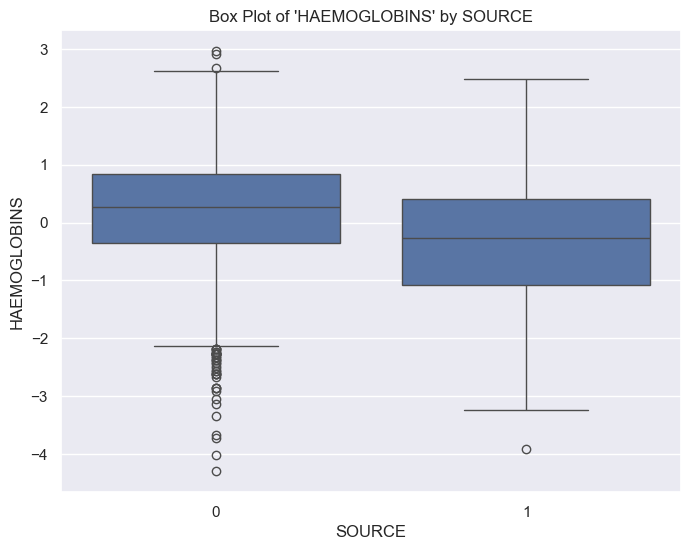

In [51]:
# Filter data by sex
data_0 = data[data['SOURCE'] == 0]
data_1 = data[data['SOURCE'] == 1]

# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='SOURCE', y='HAEMOGLOBINS', data=data)
plt.title("Box Plot of 'HAEMOGLOBINS' by SOURCE")
plt.xlabel("SOURCE")
plt.ylabel("HAEMOGLOBINS")
plt.show()

F-value: The F-value obtained from the ANOVA test is approximately 2.239. This value represents the ratio of the variance between the groups ('SOURCE' = 0 and 'SOURCE' = 1) to the variance within the groups. A larger F-value suggests that the variation between group means is greater than the variation within each group.  

P-value: The P-value associated with the F-value is approximately 0.1347. This P-value indicates the probability of observing the data if the null hypothesis were true, which posits that there is no difference in haemoglobin levels between the two groups ('SOURCE' = 0 and 'SOURCE' = 1). In this case, a P-value of 0.1347 is higher than conventional significance levels (e.g., α = 0.05), suggesting that there is no statistically significant difference in haemoglobin levels between the two groups.  

In summary, based on the results of the one-way ANOVA test, there is no statistically significant difference in the haemoglobin levels between the two groups defined by the 'SOURCE' variable.

### 4. Does the inclusion of THROMBOCYTE significantly improve the model's ability to explain the variation in the dependent variable (SOURCE)?"

In [52]:
# Define logistic regression models
# model1 = smf.logit("SOURCE ~ AGE + SEX + HAEMOGLOBINS + ERYTHROCYTE + LEUCOCYTE + THROMBOCYTE + MCHC", data=data)
# model2 = smf.logit("SOURCE ~ AGE + SEX + HAEMOGLOBINS + ERYTHROCYTE + LEUCOCYTE + THROMBOCYTE + MCHC + MCV", data=data)

model1 = smf.logit("SOURCE ~ AGE + SEX + ERYTHROCYTE + LEUCOCYTE + MCHC + MCV + HAEMOGLOBINS", data=data)
model2 = smf.logit("SOURCE ~ AGE + SEX + ERYTHROCYTE + LEUCOCYTE + MCHC + MCV + HAEMOGLOBINS + THROMBOCYTE", data=data)

# Fit the models
result1 = model1.fit()
result2 = model2.fit()

# You can still perform a likelihood ratio test between two nested models
lrt_stat = -2 * (result1.llf - result2.llf)
lrt_pval = stats.chi2.sf(lrt_stat, df=result2.df_model - result1.df_model)

print("Likelihood Ratio Test:")
print("Test Statistic:", lrt_stat)
print("p-value:", lrt_pval)

Optimization terminated successfully.
         Current function value: 0.626849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.557751
         Iterations 6
Likelihood Ratio Test:
Test Statistic: 609.7196843414413
p-value: 1.287414382188217e-134


The test statistic (11.09) indicates that the alternative model (Model 2) is significantly better than the null model (Model 1) in explaining the variation in the dependent variable (SOURCE).  
The p-value (0.00087) is extremely small, which means that the probability of observing the test statistic (or a more extreme value) under the null hypothesis is virtually zero.  
Therefore, we can reject the null hypothesis (Model 1) and conclude that the alternative model (Model 2) is a better fit to the data.  
In other words, the inclusion of the additional variable MCV in the alternative model significantly improves the model's ability to explain the variation in SOURCE. This suggests that these variables are important predictors of SOURCE.

### 5. Does the inclusion of LEUCOCYTE significantly improve the model's ability to explain the variation in the dependent variable (SOURCE)?"

In [53]:
model1 = smf.logit("SOURCE ~ AGE + SEX + ERYTHROCYTE + MCHC + MCV + HAEMOGLOBINS + THROMBOCYTE", data=data)
model2 = smf.logit("SOURCE ~ AGE + SEX + ERYTHROCYTE + MCHC + MCV + HAEMOGLOBINS + THROMBOCYTE + LEUCOCYTE", data=data)

# Fit the models
result1 = model1.fit()
result2 = model2.fit()

# You can still perform a likelihood ratio test between two nested models
lrt_stat = -2 * (result1.llf - result2.llf)
lrt_pval = stats.chi2.sf(lrt_stat, df=result2.df_model - result1.df_model)

print("Likelihood Ratio Test:")
print("Test Statistic:", lrt_stat)
print("p-value:", lrt_pval)

Optimization terminated successfully.
         Current function value: 0.570205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557751
         Iterations 6
Likelihood Ratio Test:
Test Statistic: 109.89125723403868
p-value: 1.0351642221697494e-25


### 6. Does the inclusion of HAEMOGLOBINS significantly improve the model's ability to explain the variation in the dependent variable (SOURCE)?"

In [54]:
model1 = smf.logit("SOURCE ~ AGE + SEX + ERYTHROCYTE + LEUCOCYTE + MCHC + MCV + THROMBOCYTE", data=data)
model2 = smf.logit("SOURCE ~ AGE + SEX + ERYTHROCYTE + LEUCOCYTE + MCHC + MCV + THROMBOCYTE + HAEMOGLOBINS", data=data)

# Fit the models
result1 = model1.fit()
result2 = model2.fit()

# You can still perform a likelihood ratio test between two nested models
lrt_stat = -2 * (result1.llf - result2.llf)
lrt_pval = stats.chi2.sf(lrt_stat, df=result2.df_model - result1.df_model)

print("Likelihood Ratio Test:")
print("Test Statistic:", lrt_stat)
print("p-value:", lrt_pval)

Optimization terminated successfully.
         Current function value: 0.557789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557751
         Iterations 6
Likelihood Ratio Test:
Test Statistic: 0.3316697155696602
p-value: 0.5646775492336262


### Coefficient Comparison

In [55]:
# Extract coefficients into dataframes
coef_df1 = pd.DataFrame({'Model 1 Coefficients': result1.params, 'Model 1 Std Errors': result1.bse})
coef_df2 = pd.DataFrame({'Model 2 Coefficients': result2.params, 'Model 2 Std Errors': result2.bse})

# Combine the dataframes for a side-by-side comparison
combined_df = coef_df1.join(coef_df2, how='outer')  # Use 'outer' to ensure all coefficients are shown
combined_df

Model 1 Coefficients  Model 1 Std Errors  Model 2 Coefficients  \
AGE                       0.093852            0.040003              0.096792   
ERYTHROCYTE              -0.701445            0.045702             -0.876488   
HAEMOGLOBINS                   NaN                 NaN              0.168173   
Intercept                 7.217695            0.430387              7.242195   
LEUCOCYTE                 1.033408            0.100534              1.037487   
MCHC                     -0.097270            0.037301             -0.137564   
MCV                      -0.424443            0.042253             -0.509514   
SEX[T.M]                  0.439461            0.075202              0.438334   
THROMBOCYTE              -1.855879            0.088217             -1.861856   

              Model 2 Std Errors  
AGE                     0.040351  
ERYTHROCYTE             0.308909  
HAEMOGLOBINS            0.293186  
Intercept               0.432843  
LEUCOCYTE               0.100826  
MCHC                    0.079591  
MCV                     0.154262  
SEX[T.M]                0.075246  
THROMBOCYTE             0.088904

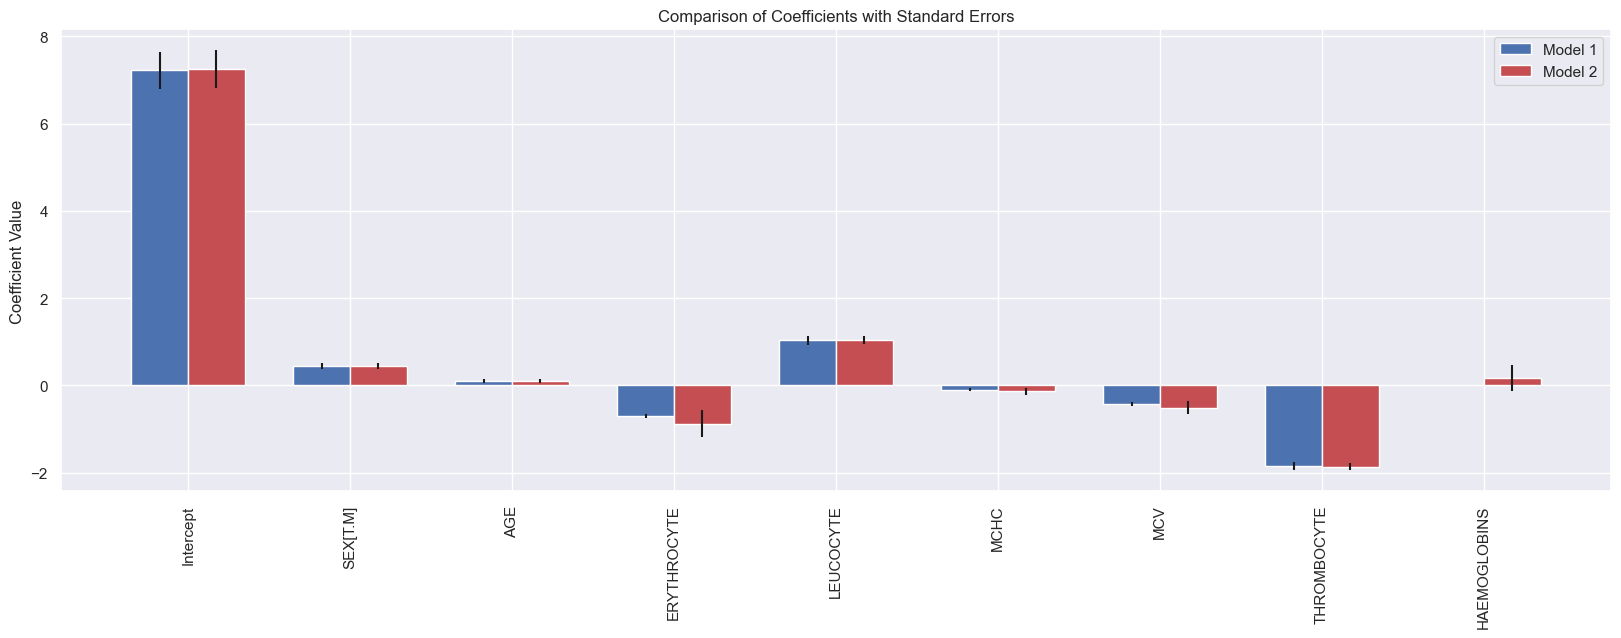

In [56]:
# Extract coefficients into dataframes
coef_df1 = pd.DataFrame({'coef': result1.params, 'err': result1.bse})
coef_df2 = pd.DataFrame({'coef': result2.params, 'err': result2.bse})

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(20, 6))

# Set dynamic index for x-axis based on the number of parameters in the larger model
index1 = np.arange(len(coef_df1))
index2 = np.arange(len(coef_df2))

# Since Model 2 may have additional coefficients, adjust the position of bars for visual clarity
width = 0.35  # Bar width

ax.bar(index1 - width/2, coef_df1['coef'], width, yerr=coef_df1['err'], label='Model 1', color='b')
ax.bar(index2 + width/2, coef_df2['coef'], width, yerr=coef_df2['err'], label='Model 2', color='r')

# Labeling
ax.set_xticks(np.arange(len(coef_df2)))  # Use the longer index list
ax.set_xticklabels(coef_df2.index, rotation=90)  # Ensure all labels are shown, including HAEMOGLOBINS
ax.set_title('Comparison of Coefficients with Standard Errors')
ax.set_ylabel('Coefficient Value')
ax.legend()

plt.show()

### Model Fit Statistics

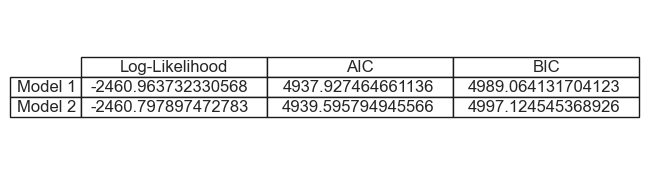

In [57]:
fig, ax = plt.subplots(figsize=(6, 2))  # Smaller figure size for textual data

# Model statistics
model_stats = {
    'Log-Likelihood': [result1.llf, result2.llf],
    'AIC': [result1.aic, result2.aic],
    'BIC': [result1.bic, result2.bic]
}
stats_df = pd.DataFrame(model_stats, index=['Model 1', 'Model 2'])

# Hide axes
ax.axis('tight')
ax.axis('off')

# Table
table = ax.table(cellText=stats_df.values, colLabels=stats_df.columns, rowLabels=stats_df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Scales the dimensions of the table

plt.show()

1. Log-Likelihood
Model 1 Log-Likelihood: 2466.490067186096
Model 2 Log-Likelihood: -2460.797897472783
The log-likelihood indicates how well the model fits the data, with a higher value (closer to zero since they are typically negative) suggesting a better fit. In your results, Model 2 has a higher log-likelihood, which means it fits the data better than Model 1. This suggests that the inclusion of the additional variable (MCV in this case, if it pertains to the models you previously described) in Model 2 has improved the model's ability to explain the variability in the data compared to Model 1.

2. Akaike Information Criterion (AIC)
Model 1 AIC: 4948.980135633619
Model 2 AIC: 4939.595794945566
The AIC is a method for model comparison which includes a penalty for the number of parameters in the model to avoid overfitting. The lower the AIC, the better the model. From your table, Model 2 has a lower AIC value, suggesting it is the preferred model after accounting for the number of parameters used. This indicates that adding MCV improves the model enough to justify the extra complexity.

3. Bayesian Information Criterion (BIC)
Model 1 BIC: 5000.116802676606
Model 2 BIC: 4997.124545368926
Similar to the AIC, the BIC also penalizes the number of parameters but does so more heavily. It also takes sample size into account. A lower BIC value suggests a better model. Again, Model 2 shows a lower BIC, indicating it is the preferred model both in terms of fitting the data well and in being sufficiently parsimonious (i.e., not using more parameters than necessary).

Summary
Both AIC and BIC indicate that Model 2 is superior to Model 1, despite adding an additional parameter. This suggests that the inclusion of the MCV variable provides significant explanatory power that outweighs the penalty for increased model complexity. This is supported by the log-likelihood values, which indicate a better fit to the data by Model 2.

---
## Classification Model

Following the classification with each of these methods, we will then evaluate each of these models using the following metrics:
* **Accuracy**: Provide the overall number of correct predictions divided by the total number of predictions.
* **Confusion Matrix**: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
* **Precision**: A measure of a classifiers exactness.
* **Recall**: A measure of a classifiers completeness
* **F2 Score** (or F-score): A weighted average of precision and recall, with more importance to recall as we want to avoid false-negative errors more than false-positive errors.

## Training and Test Data Split

In [58]:
## Train test split

# Feature set
X = data[features]
# Target set 
y = data['SOURCE']

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# train and test datasets dimensions
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3529, 8), (883, 8), (3529,), (883,))

In [59]:
# Label Encding

# Encode binary classes for the 'M' and 'F' categorical values

X_train.SEX.replace({'F':0, 'M': 1}, inplace=True)
X_test.SEX.replace({'F':0, 'M': 1}, inplace=True)

# Feature Scaling

# Based on the distribution and outliers observed in the univariate analysis we can resort to 
# using a MinMaxScaler from sklearn

# minmax = MinMaxScaler(feature_range=(0,1))
scaler = MinMaxScaler(feature_range=(0,1))

X_train[num_feats] = scaler.fit_transform(X_train[num_feats]) #fit and transform the train set
X_test[num_feats] = scaler.transform(X_test[num_feats]) #transform the test test

### 1. Logistic Regression:

The basis for choosing logistic regression is mainly given the fact that the target variable is binary in nature and we can use the logistic regression as a base model to compare with the other models.

In [60]:
logreg = LogisticRegression(random_state=42)

#Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [61]:
logreg_precision, logreg_recall, logreg_f2score, logreg_support = precision_recall_fscore_support(y_test, logreg.predict(X_test), beta=2)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
logreg_rocauc = roc_auc_score(y_test, logreg.predict(X_test))
logreg_confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))

In [62]:
print(f'---Metrics---\n accuracy: {logreg_accuracy*100:.0f}%\n precision: {logreg_precision}\n\
 recall: {logreg_recall}\n f2_score: {logreg_f2score}\n\
 ROC AUC Score: {logreg_rocauc:0.2f}\n\n\
 confusion matrix:\n {logreg_confusion_matrix}')

---Metrics---
 accuracy: 71%
 precision: [0.71118012 0.71548117]
 recall: [0.87072243 0.4789916 ]
 f2_score: [0.83333333 0.51289742]
 ROC AUC Score: 0.67

 confusion matrix:
 [[458  68]
 [186 171]]


### 2. Support Vector Machine:

In [63]:
svm =SVC(kernel='rbf', C=14, random_state=42)
svm.fit(X_train,y_train)

SVC(C=14, random_state=42)

In [64]:
svm_precision, svm_recall, svm_f2score, svm_support = precision_recall_fscore_support(y_test, svm.predict(X_test), beta=2)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test))
svm_rocauc = roc_auc_score(y_test, svm.predict(X_test))
svm_confusion_matrix = confusion_matrix(y_test, svm.predict(X_test))

In [65]:
print(f'---Metrics---\n accuracy: {svm_accuracy*100:.1f}%\n precision: {svm_precision}\n\
 recall: {svm_recall}\n f2_score: {svm_f2score}\n\
 ROC AUC Score: {svm_rocauc:0.2f}\n\n\
 confusion matrix:\n {svm_confusion_matrix}')

---Metrics---
 accuracy: 74.6%
 precision: [0.74592834 0.7472119 ]
 recall: [0.87072243 0.56302521]
 f2_score: [0.84253127 0.59222157]
 ROC AUC Score: 0.72

 confusion matrix:
 [[458  68]
 [156 201]]


### 3. K-Nearest Neighbor:

In [66]:
# Training the K-NN model on the Training set
knn = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [67]:
knn_precision, knn_recall, knn_f2score, knn_support = precision_recall_fscore_support(y_test, knn.predict(X_test), beta=2)
knn_accuracy = accuracy_score(y_test, knn.predict(X_test))
knn_rocauc = roc_auc_score(y_test, knn.predict(X_test))
knn_confusion_matrix = confusion_matrix(y_test, knn.predict(X_test))

In [68]:
print(f'---Metrics---\n accuracy: {knn_accuracy*100:.1f}%\n precision: {knn_precision}\n\
 recall: {knn_recall}\n f2_score: {knn_f2score}\n\
 ROC AUC Score: {knn_rocauc:0.2f}\n\n\
 confusion matrix:\n {knn_confusion_matrix}')

---Metrics---
 accuracy: 72.6%
 precision: [0.7414966  0.69491525]
 recall: [0.82889734 0.57422969]
 f2_score: [0.80980684 0.59489263]
 ROC AUC Score: 0.70

 confusion matrix:
 [[436  90]
 [152 205]]


### 4. Random Forest:

In [69]:
random_forest = RandomForestClassifier(n_estimators=40, random_state=42)

# Fit the model
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=40, random_state=42)

In [70]:
random_forest_precision, random_forest_recall, random_forest_f2score, random_forest_support = precision_recall_fscore_support(y_test, random_forest.predict(X_test), beta=2)
random_forest_accuracy = accuracy_score(y_test, random_forest.predict(X_test))
random_forest_rocauc = roc_auc_score(y_test, random_forest.predict(X_test))
random_forest_confusion_matrix = confusion_matrix(y_test, random_forest.predict(X_test))

In [71]:
print(f'---Metrics---\n accuracy: {random_forest_accuracy*100:.1f}%\n precision: {random_forest_precision}\n\
 recall: {random_forest_recall}\n f2_score: {random_forest_f2score}\n\
 ROC AUC Score: {random_forest_rocauc:0.2f}\n\n\
 confusion matrix:\n {random_forest_confusion_matrix}')

---Metrics---
 accuracy: 75.4%
 precision: [0.76320273 0.73648649]
 recall: [0.85171103 0.61064426]
 f2_score: [0.83240431 0.63225058]
 ROC AUC Score: 0.73

 confusion matrix:
 [[448  78]
 [139 218]]


---
## Model Optimization 

Based the performance of the models the following models selected for optimization are:



### a. Support Vector Machine:

In [72]:
# Hyperparameters
param_grid = {'C': [1, 5, 10, 20, 40, 50, 100],
              'kernel': ['rbf'],
              'degree':[1, 2, 4, 6]
             } 

# Random search for best hyperparameters
search = GridSearchCV(SVC(probability=True, random_state=42),  # Set probability to True
                      param_grid,
                      scoring='accuracy',
                      cv=3,
                      verbose=1)

search.fit(X_train, y_train)

# Best parameters for Support vector classifier
search.best_params_

best_svc = search.best_estimator_

Fitting 3 folds for each of 28 candidates, totalling 84 fits


In [73]:
# Fit the model
best_svc.fit(X_train, y_train)

svm_precision_opt, svm_recall_opt, svm_f2score_opt, svm_support_opt = precision_recall_fscore_support(y_test, best_svc.predict(X_test), beta=2)
svm_accuracy_opt = accuracy_score(y_test, best_svc.predict(X_test))


print(f'---Metrics---\n accuracy: {svm_accuracy_opt*100:.1f}%\n precision: {svm_precision_opt}\n\
 recall: {svm_recall_opt}\n f2_score: {svm_f2score_opt}')

---Metrics---
 accuracy: 74.6%
 precision: [0.74673203 0.74538745]
 recall: [0.86882129 0.56582633]
 f2_score: [0.84131075 0.59446733]


In [74]:
best_svc

SVC(C=10, degree=1, probability=True, random_state=42)

### b. K-Nearest Neighbor:

In [75]:
# GRID SEARCH
# Define the parameter values that should be searched
param_grid = {'n_neighbors': [5, 7],
              'metric': ['cosine'],
              'weights': ['distance'],
              'algorithm': ['auto'],
              'leaf_size': [10]}

# Create a base model
knn = KNeighborsClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best parameters
print(grid_search.best_params_)

# Use the best estimator for our predictions on test
best_knn = grid_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}


In [76]:
# Fit the model
best_knn.fit(X_train, y_train)

knn_precision_opt, knn_recall_opt, knn_f2score_opt, knn_support_opt = precision_recall_fscore_support(y_test, best_knn.predict(X_test), beta=2)
knn_accuracy_opt = accuracy_score(y_test, best_knn.predict(X_test))


print(f'---Metrics---\n accuracy: {knn_accuracy_opt*100:.1f}%\n precision: {knn_precision_opt}\n\
 recall: {knn_recall_opt}\n f2_score: {knn_f2score_opt}')

---Metrics---
 accuracy: 73.7%
 precision: [0.75520833 0.70358306]
 recall: [0.8269962  0.60504202]
 f2_score: [0.81156716 0.62247839]


### c. Random Forest Classifier:

In [77]:
# Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 350, 500],  # More options for number of trees
#     'max_features': ['sqrt', 'log2'],      # Two types of features to consider
#     'criterion': ['gini', 'entropy', 'log_loss'],  # Tree split criteria
#     'min_samples_leaf': [1, 2, 4],         # Minimum number of samples at leaf node
#     'min_samples_split': [2, 5, 7],        # Minimum number of samples to split
#     'max_depth': [None, 10, 20, 30],       # Maximum depth of the tree
#     'bootstrap': [True, False]             # Whether bootstrap samples are used
# }
param_grid = {'n_estimators': [350], 
              'max_features': ['log2'],
              'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_leaf': [1],
             'min_samples_split': [7],
              'max_depth' : [None],
             'bootstrap': [False]}

# Create a base model
random_forest = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(random_forest, param_grid, cv=3, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Check the best parameters
print(grid_search.best_params_)

# You can now use the best estimator for further predictions
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 350}


In [78]:
# Fit the model
best_rf.fit(X_train, y_train)

random_forest_precision_opt, random_forest_recall_opt, random_forest_f2score_opt, random_forest_support_opt = precision_recall_fscore_support(y_test, best_rf.predict(X_test), beta=2)
random_forest_accuracy_opt = accuracy_score(y_test, best_rf.predict(X_test))

print(f'---Metrics---\n accuracy: {random_forest_accuracy_opt*100:.1f}%\n precision: {random_forest_precision_opt}\n\
 recall: {random_forest_recall_opt}\n f2_score: {random_forest_f2score_opt}')

---Metrics---
 accuracy: 76.6%
 precision: [0.77547496 0.74671053]
 recall: [0.85361217 0.63585434]
 f2_score: [0.83674991 0.65531178]


#### Feature Importance

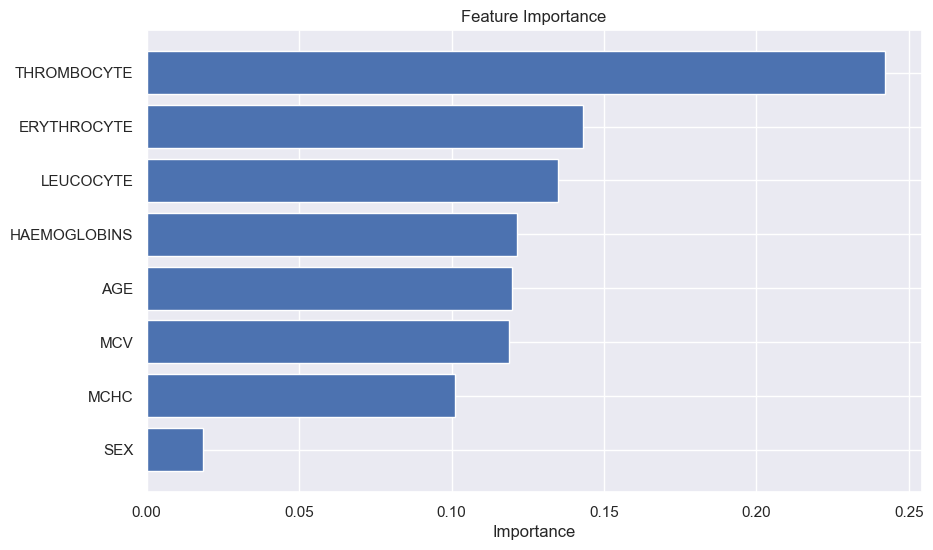

In [79]:
best_rf_feature_importance = pd.DataFrame({'features': best_rf.feature_names_in_, 'importance': best_rf.feature_importances_})
best_rf_feature_importance.sort_values(
    by='importance', 
    ascending=True, 
    inplace=True
)
plt.figure(figsize=(10, 6))
plt.barh(best_rf_feature_importance['features'], best_rf_feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

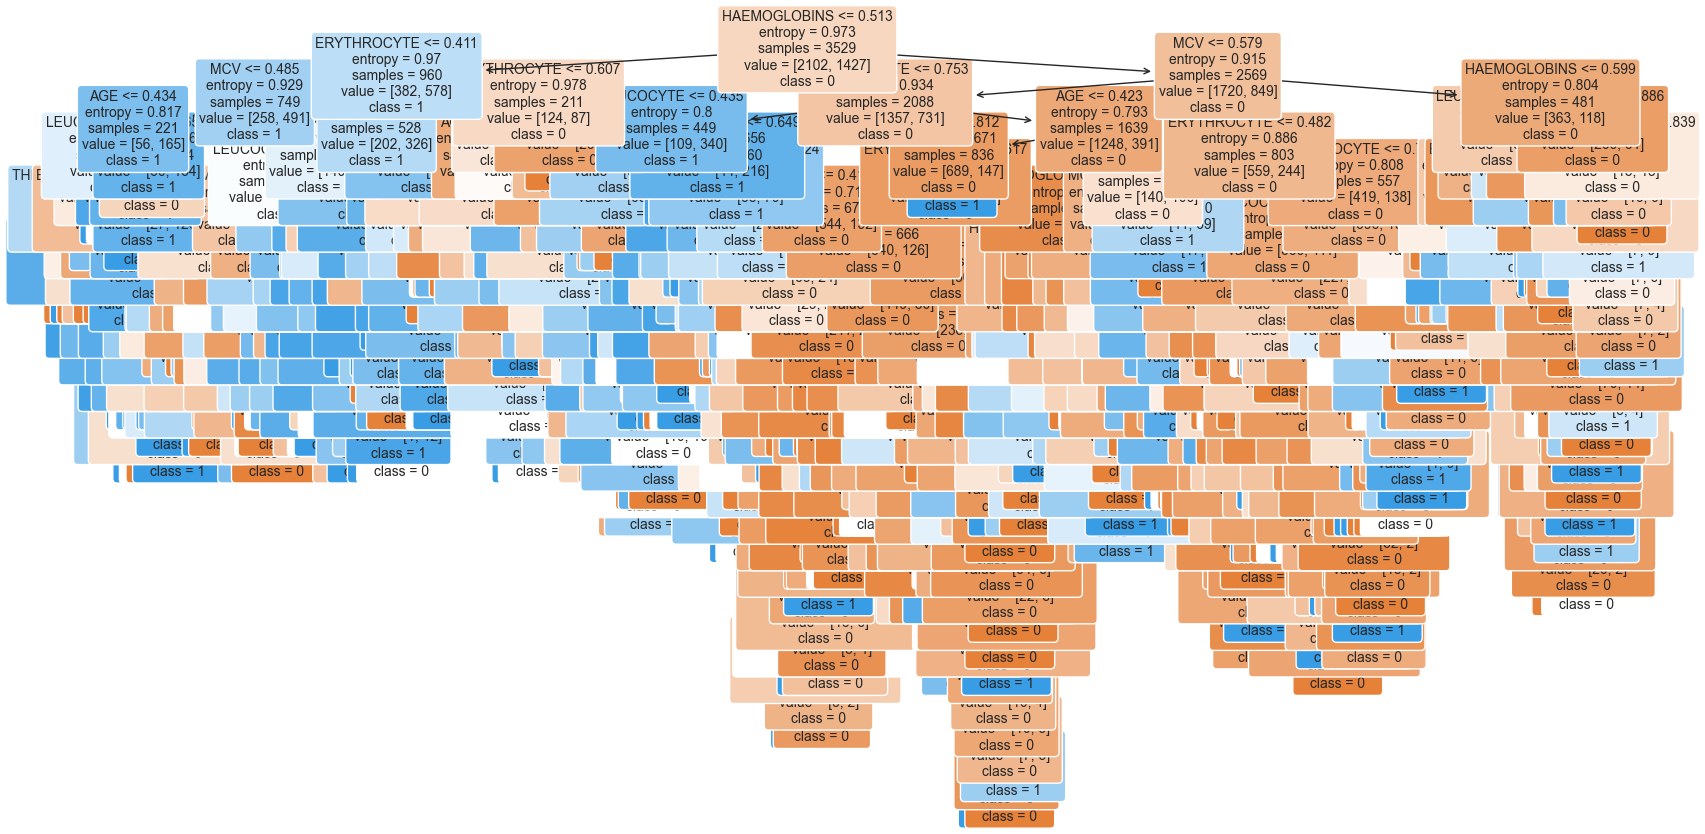

In [80]:
from sklearn import tree

# Extract one of the trees from the forest
chosen_tree = best_rf.estimators_[0]

# Reduce the figure size to something more reasonable
plt.figure(figsize=(20, 10))  # Adjusted from (200, 100) to (20, 10)

# Convert feature_names and class_names to list
feature_names_list = best_rf.feature_names_in_.tolist()
class_names_list = best_rf.classes_.astype(str).tolist()

# Plot the decision tree with limited depth
tree.plot_tree(chosen_tree,
               filled=True,
               feature_names=feature_names_list,
               class_names=class_names_list,
               rounded=True,
               fontsize=10,)
               # max_depth=3)  # Limiting the depth to make the tree smaller and less complex
plt.show()

---
## Results

In [81]:
# Create a function to plot confusion matrix and classification metrics
def plot_cm(cm, precision, recall, f2score, accuracy, title):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    
    plt.subplot(1, 2, 2)
    metrics = [precision, recall, f2score, accuracy]
    metric_names = ['Precision', 'Recall', 'F2 Score', 'Accuracy']
    bar_plot = sns.barplot(x=metric_names, y=metrics)
    plt.ylim(0, 1)
    
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.2f'),  # Format the value to 2 decimal places
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                        ha='center', va='center',  # Center alignment
                        xytext=(0, 9),  # Position text 9 points above the top of the bar
                        textcoords='offset points')    
    plt.suptitle(title, size = 15)

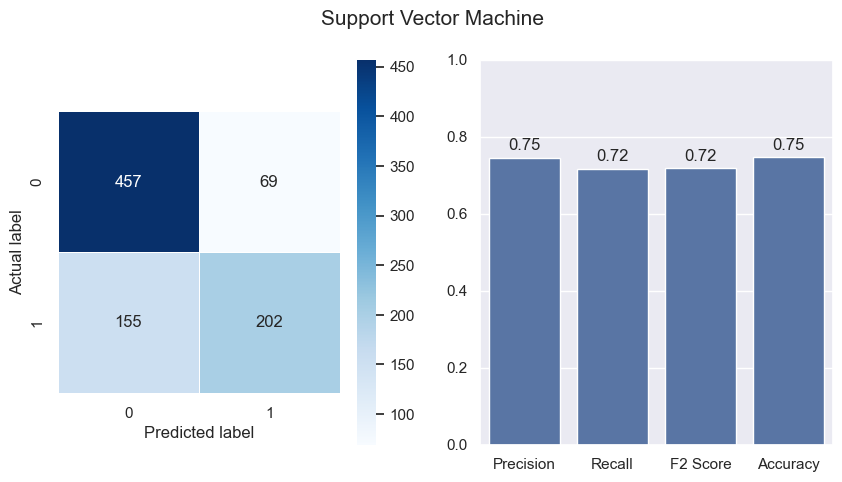

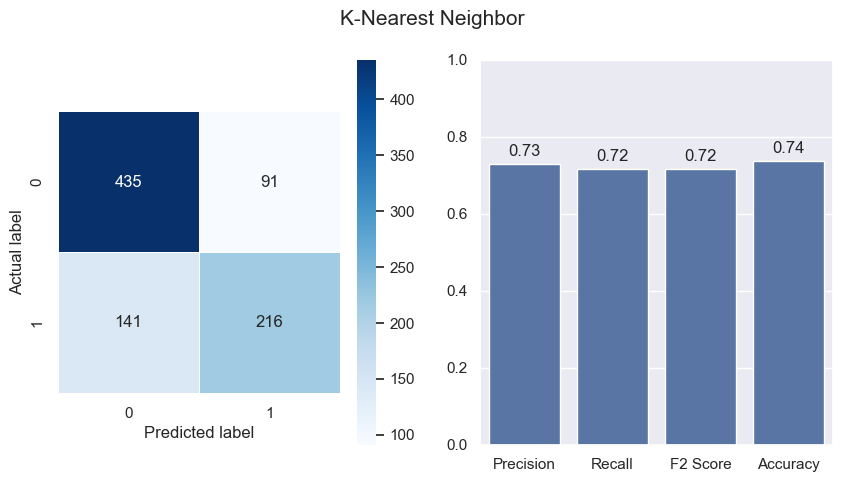

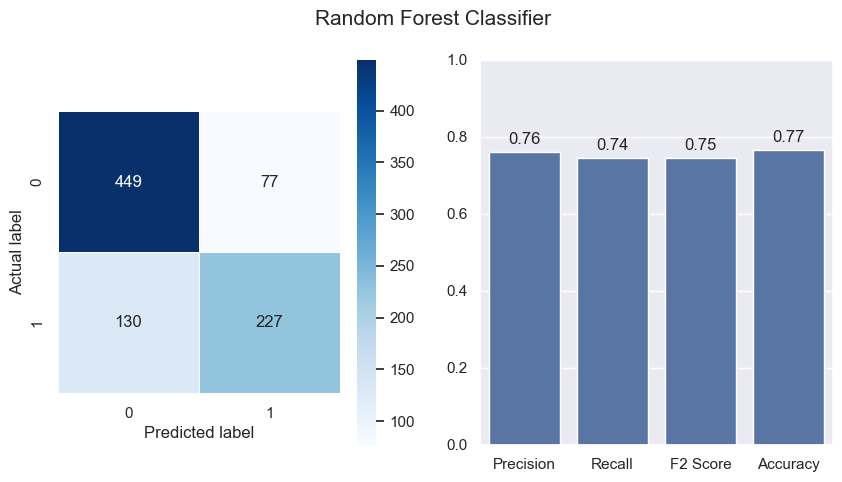

In [82]:
# Compute average metrics
svm_precision_opt_avg = np.mean(svm_precision_opt)
svm_recall_opt_avg = np.mean(svm_recall_opt)
svm_f2score_opt_avg = np.mean(svm_f2score_opt)

knn_precision_opt_avg = np.mean(knn_precision_opt)
knn_recall_opt_avg = np.mean(knn_recall_opt)
knn_f2score_opt_avg = np.mean(knn_f2score_opt)

random_forest_precision_opt_avg = np.mean(random_forest_precision_opt)
random_forest_recall_opt_avg = np.mean(random_forest_recall_opt)
random_forest_f2score_opt_avg = np.mean(random_forest_f2score_opt)

# Compute confusion matrices
cm_svm = confusion_matrix(y_test, best_svc.predict(X_test))
cm_knn = confusion_matrix(y_test, best_knn.predict(X_test))
cm_rf = confusion_matrix(y_test, best_rf.predict(X_test))

# Plot confusion matrices and classification metrics
plot_cm(cm_svm, svm_precision_opt_avg, svm_recall_opt_avg, svm_f2score_opt_avg, svm_accuracy_opt, 'Support Vector Machine')
plot_cm(cm_knn, knn_precision_opt_avg, knn_recall_opt_avg, knn_f2score_opt_avg, knn_accuracy_opt, 'K-Nearest Neighbor')
plot_cm(cm_rf, random_forest_precision_opt_avg, random_forest_recall_opt_avg, random_forest_f2score_opt_avg, random_forest_accuracy_opt, 'Random Forest Classifier')


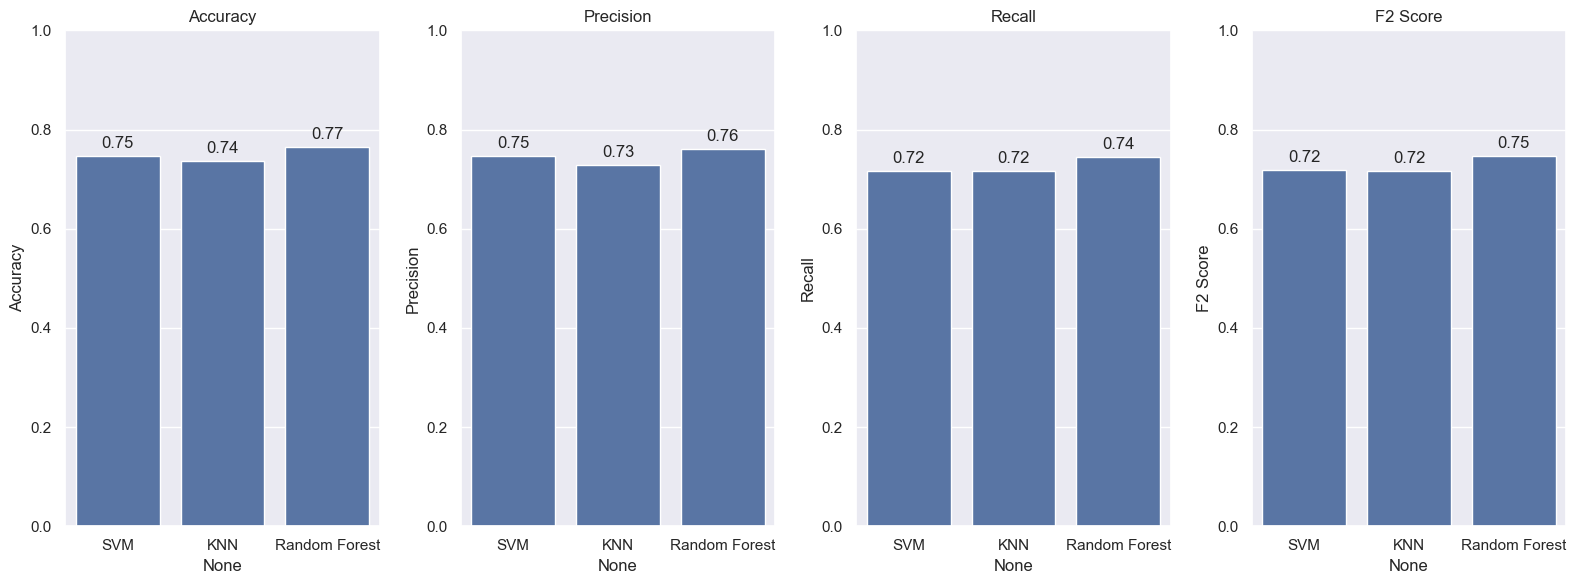

In [83]:
# Compute averages
metrics_data = {
    'Accuracy': [svm_accuracy_opt, knn_accuracy_opt, random_forest_accuracy_opt],
    'Precision': [np.mean(svm_precision_opt), np.mean(knn_precision_opt), np.mean(random_forest_precision_opt)],
    'Recall': [np.mean(svm_recall_opt), np.mean(knn_recall_opt), np.mean(random_forest_recall_opt)],
    'F2 Score': [np.mean(svm_f2score_opt), np.mean(knn_f2score_opt), np.mean(random_forest_f2score_opt)]
}
algorithms = ['SVM', 'KNN', 'Random Forest']

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_data, index=algorithms)

# Plotting
plt.figure(figsize=(16, 6))
for i, column in enumerate(df_metrics.columns):
    plt.subplot(1, 4, i+1)
    sns.barplot(x=df_metrics.index, y=df_metrics[column])
    plt.title(column)
    plt.ylim(0, 1)
    for p in plt.gca().patches:  # Add value annotations
        plt.gca().annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', 
                           xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

In [84]:
confusion_matrix(y_test, best_svc.predict(X_test))

array([[457,  69],
       [155, 202]], dtype=int64)

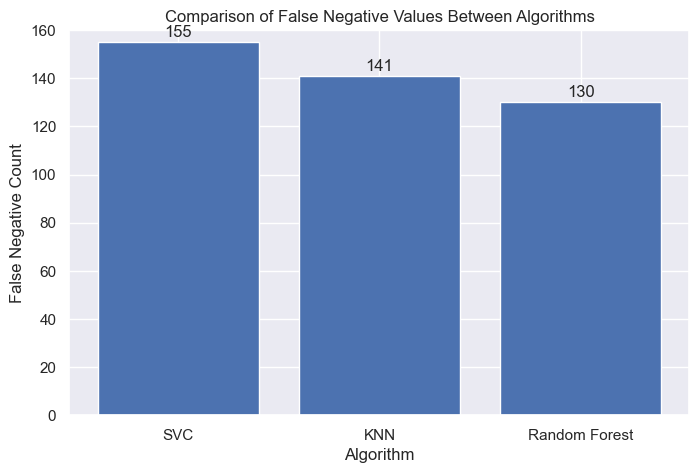

In [85]:
tn_svc, fp_svc, fn_svc, tp_svc = confusion_matrix(y_test, best_svc.predict(X_test)).ravel()
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test, best_knn.predict(X_test)).ravel()
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, best_rf.predict(X_test)).ravel()

# Names of algorithms
algorithms = ['SVC', 'KNN', 'Random Forest']

# Corresponding FN values
fn_values = [fn_svc, fn_knn, fn_rf]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(algorithms, fn_values)

# Adding titles and labels
plt.title('Comparison of False Negative Values Between Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('False Negative Count')
plt.ylim(0, max(fn_values) + 5)  # Setting the y-limit a bit higher for better visualization

# Adding value labels on top of each bar
for i, value in enumerate(fn_values):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')  # Adjust text alignment and position

plt.show()

Usually, in medical case, False Negative cases are more important than precision as it is “How many test incorrectly indicates that a person does not have a disease when they actually do”
In our case, we are trying to reduce FN (Actual: Inpatient (1) but Predict Outpatient (1))
RF has the least FN prediction

In [86]:
y_test_pred = best_svc.predict(X_test)
y_test_pred = pd.DataFrame({'predicted' : y_test_pred})
X_test.reset_index(drop=True, inplace=True)
X_y_test_pred = pd.concat([X_test, y_test_pred], axis=1)
X_y_test_pred.head()

HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE      MCHC       MCV  \
0      0.754967     0.625392   0.668919     0.849464  0.538462  0.488636   
1      0.701987     0.620690   0.388548     0.873491  0.600000  0.394481   
2      0.403974     0.297806   0.871871     0.885625  0.638462  0.511364   
3      0.245033     0.155172   0.825048     0.519927  0.661538  0.550325   
4      0.668874     0.500000   0.603624     0.854658  0.700000  0.500000   

        AGE  SEX  predicted  
0  0.489796    1          0  
1  0.102041    1          0  
2  0.663265    1          1  
3  0.765306    1          1  
4  0.244898    0          0

In [87]:
# Predict probabilities for ROC curve calculation
y_scores_rf = best_rf.predict_proba(X_test)[:, 1]  # Probability of the positive class
y_scores_svc = best_svc.predict_proba(X_test)[:, 1]
y_scores_knn = best_knn.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_scores_svc)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scores_knn)

# Calculate Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)
precision_svc, recall_svc, _ = precision_recall_curve(y_test, y_scores_svc)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_scores_knn)

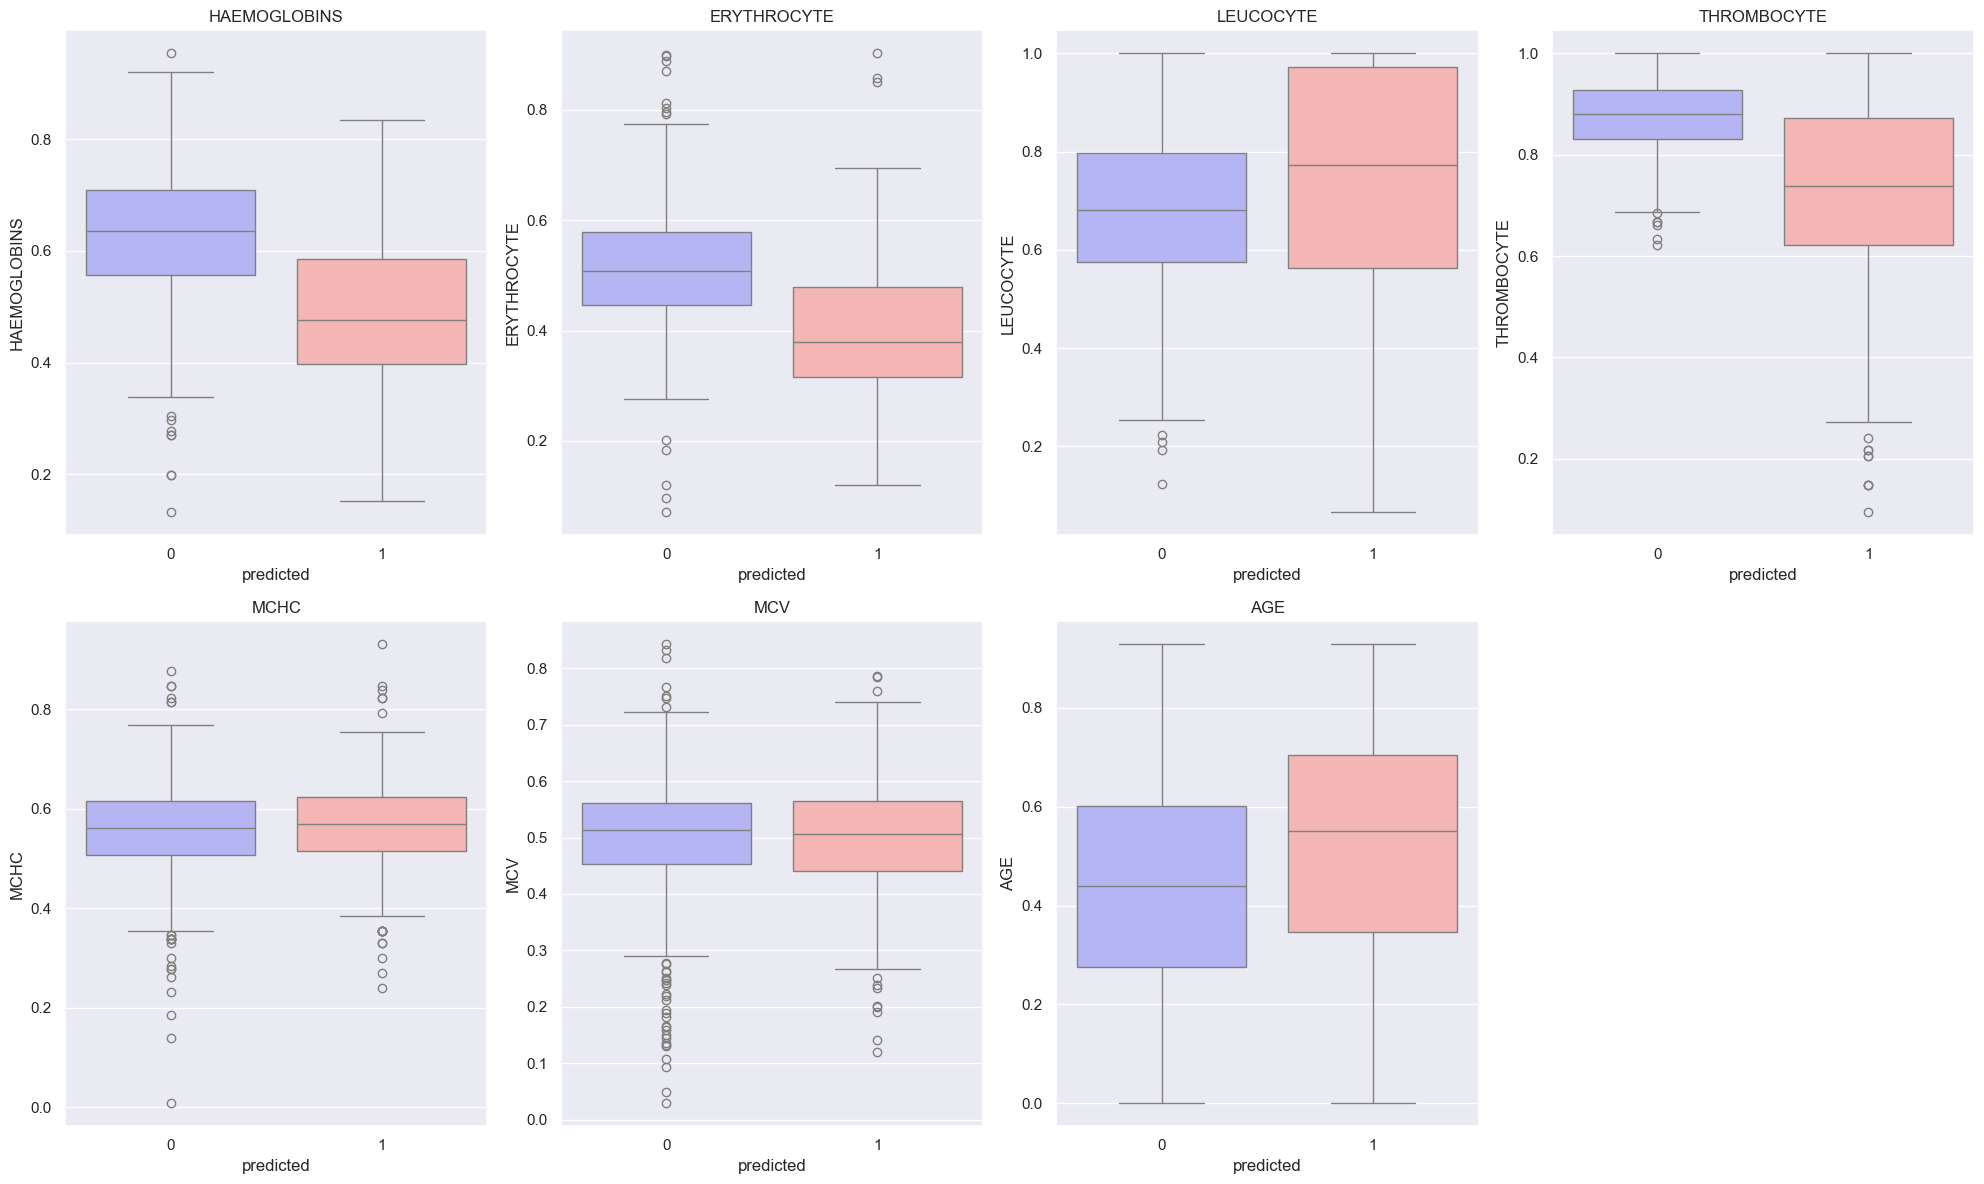

In [88]:
# Setting up the figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12))  # Adjust the figsize to fit your display
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Box Plots for each feature
features = ['HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE', 'THROMBOCYTE', 'MCHC', 'MCV', 'AGE']
for i, feature in enumerate(features):
    sns.boxplot(x='predicted', y=feature, data=X_y_test_pred, palette='bwr', ax=axes[i])
    axes[i].set_title(f'{feature}')

# If there's an empty subplot, hide it
if len(axes) > len(features):
    for ax in axes[len(features):]:
        ax.axis('off')

plt.tight_layout()
plt.show()

From the plots, we could see from the prediction that:

1. Haemoglobins (Protein containing iron that facilitates the transport of oxygen in red blood cells) and Erythrocyte (Red blood cell): The patients who are admitted as in-patients tend to have lower Haemoglobins and Erythrocyte because of
   - Increased Severity of Underlying Conditions: Low hemoglobin often signals severe or uncontrolled disease states, such as advanced kidney disease or cancers, which require intensive management and monitoring.
   - Complications of Anemia: Severe anemia can lead to significant complications requiring hospitalization, such as heart problems (like heart failure), severe fatigue, and other organ dysfunctions due to poor oxygenation.
   - Acute and Chronic Complications: With fewer red blood cells to transport oxygen, critical organs and tissues do not receive the oxygen they need, which can lead to complications such as organ failure, severe weakness, and in some cases, life-threatening conditions that necessitate immediate hospital care.

2. With the same reasons as above, We could see that the patients who are admitted as in-patients tend to have slightly lower MCHC (Mean Corpuscular Hemoglobin Concentration, Represents the average concentration of hemoglobin within red blood cells) and 
MCV (Mean Corpuscular Volume or the average size of red blood cells)

3. Thrombocyte (Blood clotting palette): The patients who are admitted as in-patients tend to have lower Thrombocyte because of
   - Increased Bleeding Risk: The primary function of thrombocytes (platelets) is to help blood clot. A low platelet count can lead to easy or excessive bleeding, which might not stop on its own after an injury or surgery. This condition can manifest as frequent nosebleeds, gum bleeding, heavy menstrual periods, or severe bruising. In some cases, internal bleeding can occur, which can be life-threatening and requires immediate medical attention.

4. However, the patients who are admitted as in-patients tend to have higher Leucocyte (White blood cell) because:
   - Increased Risk of Thrombosis: One of the main risks associated with high thrombocyte counts is an increased likelihood of developing blood clots (thrombosis). These clots can form in arteries or veins and may lead to serious conditions such as deep vein thrombosis, pulmonary embolism, or stroke, depending on where the clot forms. Such events often require immediate hospital care.
   - Underlying Health Conditions: Secondary thrombocytosis can be a response to another condition, such as inflammation, infection, cancer, or anemia. Identifying and managing these underlying conditions often necessitates detailed evaluation and treatment in a hospital setting. Primary thrombocytosis, often due to a myeloproliferative disorder, requires careful monitoring and management to prevent complications.

5. Lastly, older-aged patients have a higher chance of being admitted.

- 1: In-patient
- 0: Out-patient

---

### Interpreting the results:

* In terms of accuracy i.e., the overall number of correct predictions, Random Forest shows a clear superiority with 76.8% followed by KNN with 74.9% and SVM with 74.7%.

* Using the F2 score that bears more weight to the recall which shows the percentange of relevant data points correctly classified by the models, we again see Random Forest clearly win over KNN and SVM. Howevewr, SVM performs slightly better in predicting the out patient data (0.83) while KNN performs better in predicting the in patient data (0.64) between the two.


---
## Discussion

The random forest is a sutiable model to aid in the patient classification task of patients to be admitted to the in patient and out patient units based on the electronic health records porvided. The features chosen after dropping the Haematocrit and MCH values still provided a valuable classification result.

However, there is further scope to improve with potentially a larger collection of patient records as well as further investigation of the dataset using factor analysis or other methods that can help reduce the dimensionality of the feature set. 